### Custom Datasets with PyTorch

PyTorch Domain Libraries:
    
    
Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.
    
![PyTorch Domain Libraries](custom1.png)
![Libraries](custom2.png)

What are we going to cover?

* Getting a custom dataset with PyTorch
* Becoming one with the data (preparing and visualizing)
* Transforming data for use with a model
* Loading custom data with pre-built functions and custom functions.
* Building FoodVisionMini to classify food images.
* Comparing models with and without data augmentation
* Making predictions on custom data.

### Table of Contents
1. [Importing PyTorch and setting up device agnostic code](#agnostic)
    * 1.1 [Custom Dataset Creation](#get-data)
2. [Becoming one with the data (Data Preparation and Data Exploration)](#exploration)
    * 2.1 [Visualizing an image](#visualize)
3. [Transforming Data](#transform)
    * 3.1 [Transforming data with `torchvision.transforms`](#torchvision-transform)
    * 3.2 [Visualizing our Transformed image](#transformed-image)
4. [Option 1: Loading image data using `ImageFolder`](#load-image)
    * 4.1 [Turn loaded images into `DataLoader's`](#dataloader)
5. [Option 2: Loading Image Data with a Custom `Dataset` ](#load_customdataset)
    * 5.1 [Creating a helper function to get class names](#helper_function)
    * 5.2 [Create a custom `Dataset` to replicate `ImageFolder`](#replicate-imagefolder)
    * 5.3 [Create a function to display random images](#display-images)
    * 5.4 [Turn custom loaded images into `DataLoader`'s](#custom-dataloader)
6. [Other forms of transforms (Data Augmentation)](#augmentation)
7. [Model 0 : TinyVGG without Data Augmentation](#model-0)
    * 7.1 [Creating transforms and loading data for Model 0](#load-model-0)
    * 7.2 [Create TinyVGG Model Class](#create-model-0)
    * 7.3 [Try a forward pass on a single image (to test the model)](#forwardpass)
    * 7.4 [Use `torchinfo` to get an idea of the shapes going through our model](#torchinfo)
    * 7.5 [Creating train and test loop functions](#loop)
    * 7.6 [Creating a `train()` function to combine `train_step()` and `test_step()`](#train())
    * 7.7 [Train and evaluate model 0](#evaluate-model0)
    * 7.8 [Plot the loss curves of Model 0](#plot-model0)
 8. [What should an ideal loss curve look like?](#ideal-curve)
 9. [Model 1: TingVGG with Data Augmentation](#model1)
     * 9.1 [Create transform with data augmentation](#model1-transform)
     * 9.2 [Create train and test `Dataset`'s and `DataLoader`'s with Data Augmentation](#model1-dataloader)
     * 9.3 [Construct and train Model 1](#model1-construct)
     * 9.4 [Plot the loss curves of model 1](#model1-plot)
10. [Compare model results](#model_result)
11. [Making a prediction on a custom image](#prediction)
    * 11.1 [Loading in a custom image with PyTorch](#customimage)
    * 11.2 [Making a prediction on a custom image with a trained PyTorch model](#custompred)
    * 11.3 [Putting custom image prediction together: Building a function](#buildfunction)
12. [Saving and loading the best model](#savemodel)

### 1. Importing PyTorch and setting up device agnostic code<a class='anchor' id ='agnostic'>

In [1]:
import torch
from torch import nn

torch.__version__

'2.0.1'

In [2]:
# Setup device-agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#### 1.1 Custom Dataset Creation <a class='anchor' id ='get-data'>

In [3]:
import torch
import torchvision

import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Set data directory
import pathlib
data_dir = pathlib.Path("datas")

In [4]:
# Get the Food101 dataset from PyTorch
# Food101 in torchvision.datasets

# Get training data
train_data = datasets.Food101(root     = data_dir,
                              split    = "train",
                              download = True)

# Get testing data
test_data  = datasets.Food101(root     = data_dir,
                              split    = "test",
                              download = True)


In [5]:
train_data

Dataset Food101
    Number of datapoints: 75750
    Root location: datas
    split=train

In [6]:
test_data

Dataset Food101
    Number of datapoints: 25250
    Root location: datas
    split=test

In [7]:
class_names = train_data.classes
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

churros


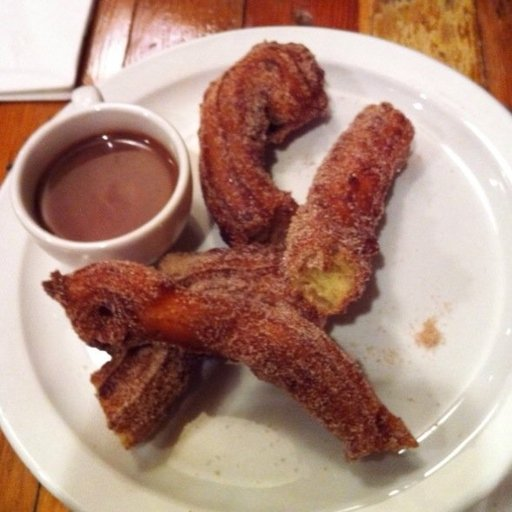

In [8]:
# View first sample (PIL Image format)
print(class_names[train_data[0][1]])
train_data[0][0]

#### Finding subset of appropriate classes

Want: apple_pie, cheesecake, chocolate_mousse, red_velvet_cake, waffles

Current path setup:

     ../data/food-101/images/CLASS_NAME/IMAGES.JPG
     
Going to get a list of the different target image classes (apple_pie, cheesecake, chocolate_mousse, red_velvet_cake, waffles) filenames and then copy the images to seperate folders.

I'd like to get a random 10% of the images from the target classes from both datasets.

In [9]:
# Get random 10% of training images
import random

# Setup data paths
data_path      = data_dir / "food-101" / "images"
target_classes = ["apple_pie","cheesecake", "chocolate_mousse", "red_velvet_cake","waffles"]

# Change amount of data to get (e.g. 0.1 = random 10%, 0.2 = random 20%)
amount_to_get  = 1.0

# Create function to seperate a random amount of data
def get_subset(image_path     = data_path,
               data_splits    = ["train","test"],
               target_classes = ["apple_pie","cheesecake", "chocolate_mousse", "red_velvet_cake","waffles"],
               amount         = 1.0,
               seed           = 99):
    random.seed(99)
    label_splits = {}
    
    # Get labels
    for data_split in data_splits:
        print(f"[INFO] Creating image split for: {data_split}...")
        label_path = data_dir / "food-101" /"meta" / f"{data_split}.txt"
        with open(label_path,"r") as f:
            labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes]
            
        # Get random subset of target classes image ID's
        number_to_sample         = round(amount * len(labels))
        print(f"[INFO] Getting random subset of {number_to_sample} images for {data_split}...")
        sampled_images           = random.sample(labels, k=number_to_sample)
        
        # Apply full paths
        image_paths              = [pathlib.Path(str(image_path/sample_image) + ".jpg") for sample_image in sampled_images]
        label_splits[data_split] = image_paths
    return label_splits

label_splits = get_subset(amount = amount_to_get)
label_splits["train"][:10]

[INFO] Creating image split for: train...
[INFO] Getting random subset of 3750 images for train...
[INFO] Creating image split for: test...
[INFO] Getting random subset of 1250 images for test...


[PosixPath('datas/food-101/images/chocolate_mousse/1759626.jpg'),
 PosixPath('datas/food-101/images/chocolate_mousse/1357498.jpg'),
 PosixPath('datas/food-101/images/cheesecake/1389466.jpg'),
 PosixPath('datas/food-101/images/red_velvet_cake/1923799.jpg'),
 PosixPath('datas/food-101/images/apple_pie/939768.jpg'),
 PosixPath('datas/food-101/images/cheesecake/1954335.jpg'),
 PosixPath('datas/food-101/images/cheesecake/2360871.jpg'),
 PosixPath('datas/food-101/images/apple_pie/3545924.jpg'),
 PosixPath('datas/food-101/images/waffles/1539206.jpg'),
 PosixPath('datas/food-101/images/apple_pie/2705419.jpg')]

#### Move training and testing image to dedicated folders

In [10]:
import os
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /Users/ritikagupta/Desktop/Pytorch


In [11]:
# Create target directory path
target_dir_name = f"datas/Chocolates{str(int(amount_to_get*100))}_percent"

print(f"Creating directory: '{target_dir_name}'")
# Setup the directories
target_dir = pathlib.Path(target_dir_name)

# Make the directories
target_dir.mkdir(parents = True, exist_ok = True)


Creating directory: 'datas/Chocolates100_percent'


In [12]:
import shutil

for image_split in label_splits.keys():
    for image_path in label_splits[str(image_split)]:
        print(image_path)
        dest_dir = target_dir / image_split / image_path.parent.stem / image_path.name
        print(dest_dir)
        if not dest_dir.parent.is_dir():
            dest_dir.parent.mkdir(parents = True, exist_ok = True)
        print(f"[INFO] Copying {image_path} to {dest_dir}...")
        shutil.copy2(image_path,dest_dir)

datas/food-101/images/chocolate_mousse/1759626.jpg
datas/Chocolates100_percent/train/chocolate_mousse/1759626.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/1759626.jpg to datas/Chocolates100_percent/train/chocolate_mousse/1759626.jpg...
datas/food-101/images/chocolate_mousse/1357498.jpg
datas/Chocolates100_percent/train/chocolate_mousse/1357498.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/1357498.jpg to datas/Chocolates100_percent/train/chocolate_mousse/1357498.jpg...
datas/food-101/images/cheesecake/1389466.jpg
datas/Chocolates100_percent/train/cheesecake/1389466.jpg
[INFO] Copying datas/food-101/images/cheesecake/1389466.jpg to datas/Chocolates100_percent/train/cheesecake/1389466.jpg...
datas/food-101/images/red_velvet_cake/1923799.jpg
datas/Chocolates100_percent/train/red_velvet_cake/1923799.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/1923799.jpg to datas/Chocolates100_percent/train/red_velvet_cake/1923799.jpg...
datas/food-101/images/apple_pie/

datas/food-101/images/cheesecake/708936.jpg
datas/Chocolates100_percent/train/cheesecake/708936.jpg
[INFO] Copying datas/food-101/images/cheesecake/708936.jpg to datas/Chocolates100_percent/train/cheesecake/708936.jpg...
datas/food-101/images/red_velvet_cake/3662723.jpg
datas/Chocolates100_percent/train/red_velvet_cake/3662723.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/3662723.jpg to datas/Chocolates100_percent/train/red_velvet_cake/3662723.jpg...
datas/food-101/images/chocolate_mousse/3077113.jpg
datas/Chocolates100_percent/train/chocolate_mousse/3077113.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/3077113.jpg to datas/Chocolates100_percent/train/chocolate_mousse/3077113.jpg...
datas/food-101/images/apple_pie/2151461.jpg
datas/Chocolates100_percent/train/apple_pie/2151461.jpg
[INFO] Copying datas/food-101/images/apple_pie/2151461.jpg to datas/Chocolates100_percent/train/apple_pie/2151461.jpg...
datas/food-101/images/apple_pie/3468573.jpg
datas/Chocolates100_

datas/food-101/images/chocolate_mousse/1391868.jpg
datas/Chocolates100_percent/train/chocolate_mousse/1391868.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/1391868.jpg to datas/Chocolates100_percent/train/chocolate_mousse/1391868.jpg...
datas/food-101/images/cheesecake/3267121.jpg
datas/Chocolates100_percent/train/cheesecake/3267121.jpg
[INFO] Copying datas/food-101/images/cheesecake/3267121.jpg to datas/Chocolates100_percent/train/cheesecake/3267121.jpg...
datas/food-101/images/chocolate_mousse/2384213.jpg
datas/Chocolates100_percent/train/chocolate_mousse/2384213.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/2384213.jpg to datas/Chocolates100_percent/train/chocolate_mousse/2384213.jpg...
datas/food-101/images/waffles/1386687.jpg
datas/Chocolates100_percent/train/waffles/1386687.jpg
[INFO] Copying datas/food-101/images/waffles/1386687.jpg to datas/Chocolates100_percent/train/waffles/1386687.jpg...
datas/food-101/images/apple_pie/2605751.jpg
datas/Chocolates100_

datas/food-101/images/chocolate_mousse/639284.jpg
datas/Chocolates100_percent/train/chocolate_mousse/639284.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/639284.jpg to datas/Chocolates100_percent/train/chocolate_mousse/639284.jpg...
datas/food-101/images/red_velvet_cake/2354303.jpg
datas/Chocolates100_percent/train/red_velvet_cake/2354303.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/2354303.jpg to datas/Chocolates100_percent/train/red_velvet_cake/2354303.jpg...
datas/food-101/images/red_velvet_cake/228477.jpg
datas/Chocolates100_percent/train/red_velvet_cake/228477.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/228477.jpg to datas/Chocolates100_percent/train/red_velvet_cake/228477.jpg...
datas/food-101/images/waffles/1665561.jpg
datas/Chocolates100_percent/train/waffles/1665561.jpg
[INFO] Copying datas/food-101/images/waffles/1665561.jpg to datas/Chocolates100_percent/train/waffles/1665561.jpg...
datas/food-101/images/red_velvet_cake/2427823.jpg
datas/

datas/food-101/images/waffles/961486.jpg
datas/Chocolates100_percent/train/waffles/961486.jpg
[INFO] Copying datas/food-101/images/waffles/961486.jpg to datas/Chocolates100_percent/train/waffles/961486.jpg...
datas/food-101/images/apple_pie/1659828.jpg
datas/Chocolates100_percent/train/apple_pie/1659828.jpg
[INFO] Copying datas/food-101/images/apple_pie/1659828.jpg to datas/Chocolates100_percent/train/apple_pie/1659828.jpg...
datas/food-101/images/waffles/1527411.jpg
datas/Chocolates100_percent/train/waffles/1527411.jpg
[INFO] Copying datas/food-101/images/waffles/1527411.jpg to datas/Chocolates100_percent/train/waffles/1527411.jpg...
datas/food-101/images/chocolate_mousse/3898445.jpg
datas/Chocolates100_percent/train/chocolate_mousse/3898445.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/3898445.jpg to datas/Chocolates100_percent/train/chocolate_mousse/3898445.jpg...
datas/food-101/images/red_velvet_cake/2723145.jpg
datas/Chocolates100_percent/train/red_velvet_cake/2723145.

datas/food-101/images/waffles/629565.jpg
datas/Chocolates100_percent/train/waffles/629565.jpg
[INFO] Copying datas/food-101/images/waffles/629565.jpg to datas/Chocolates100_percent/train/waffles/629565.jpg...
datas/food-101/images/chocolate_mousse/3886182.jpg
datas/Chocolates100_percent/train/chocolate_mousse/3886182.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/3886182.jpg to datas/Chocolates100_percent/train/chocolate_mousse/3886182.jpg...
datas/food-101/images/red_velvet_cake/59791.jpg
datas/Chocolates100_percent/train/red_velvet_cake/59791.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/59791.jpg to datas/Chocolates100_percent/train/red_velvet_cake/59791.jpg...
datas/food-101/images/waffles/1793231.jpg
datas/Chocolates100_percent/train/waffles/1793231.jpg
[INFO] Copying datas/food-101/images/waffles/1793231.jpg to datas/Chocolates100_percent/train/waffles/1793231.jpg...
datas/food-101/images/cheesecake/192339.jpg
datas/Chocolates100_percent/train/cheesecake/192

datas/food-101/images/red_velvet_cake/2373461.jpg
datas/Chocolates100_percent/train/red_velvet_cake/2373461.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/2373461.jpg to datas/Chocolates100_percent/train/red_velvet_cake/2373461.jpg...
datas/food-101/images/apple_pie/1575505.jpg
datas/Chocolates100_percent/train/apple_pie/1575505.jpg
[INFO] Copying datas/food-101/images/apple_pie/1575505.jpg to datas/Chocolates100_percent/train/apple_pie/1575505.jpg...
datas/food-101/images/apple_pie/1771395.jpg
datas/Chocolates100_percent/train/apple_pie/1771395.jpg
[INFO] Copying datas/food-101/images/apple_pie/1771395.jpg to datas/Chocolates100_percent/train/apple_pie/1771395.jpg...
datas/food-101/images/chocolate_mousse/2374973.jpg
datas/Chocolates100_percent/train/chocolate_mousse/2374973.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/2374973.jpg to datas/Chocolates100_percent/train/chocolate_mousse/2374973.jpg...
datas/food-101/images/apple_pie/2306493.jpg
datas/Chocolates100_

datas/food-101/images/waffles/1377375.jpg
datas/Chocolates100_percent/train/waffles/1377375.jpg
[INFO] Copying datas/food-101/images/waffles/1377375.jpg to datas/Chocolates100_percent/train/waffles/1377375.jpg...
datas/food-101/images/red_velvet_cake/167227.jpg
datas/Chocolates100_percent/train/red_velvet_cake/167227.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/167227.jpg to datas/Chocolates100_percent/train/red_velvet_cake/167227.jpg...
datas/food-101/images/red_velvet_cake/1559809.jpg
datas/Chocolates100_percent/train/red_velvet_cake/1559809.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/1559809.jpg to datas/Chocolates100_percent/train/red_velvet_cake/1559809.jpg...
datas/food-101/images/waffles/1141046.jpg
datas/Chocolates100_percent/train/waffles/1141046.jpg
[INFO] Copying datas/food-101/images/waffles/1141046.jpg to datas/Chocolates100_percent/train/waffles/1141046.jpg...
datas/food-101/images/apple_pie/136256.jpg
datas/Chocolates100_percent/train/apple_pie/1

datas/food-101/images/cheesecake/1142851.jpg
datas/Chocolates100_percent/train/cheesecake/1142851.jpg
[INFO] Copying datas/food-101/images/cheesecake/1142851.jpg to datas/Chocolates100_percent/train/cheesecake/1142851.jpg...
datas/food-101/images/apple_pie/2735451.jpg
datas/Chocolates100_percent/train/apple_pie/2735451.jpg
[INFO] Copying datas/food-101/images/apple_pie/2735451.jpg to datas/Chocolates100_percent/train/apple_pie/2735451.jpg...
datas/food-101/images/red_velvet_cake/2201801.jpg
datas/Chocolates100_percent/train/red_velvet_cake/2201801.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/2201801.jpg to datas/Chocolates100_percent/train/red_velvet_cake/2201801.jpg...
datas/food-101/images/apple_pie/3047214.jpg
datas/Chocolates100_percent/train/apple_pie/3047214.jpg
[INFO] Copying datas/food-101/images/apple_pie/3047214.jpg to datas/Chocolates100_percent/train/apple_pie/3047214.jpg...
datas/food-101/images/cheesecake/3752667.jpg
datas/Chocolates100_percent/train/cheesecak

datas/food-101/images/chocolate_mousse/3057195.jpg
datas/Chocolates100_percent/train/chocolate_mousse/3057195.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/3057195.jpg to datas/Chocolates100_percent/train/chocolate_mousse/3057195.jpg...
datas/food-101/images/chocolate_mousse/1508926.jpg
datas/Chocolates100_percent/train/chocolate_mousse/1508926.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/1508926.jpg to datas/Chocolates100_percent/train/chocolate_mousse/1508926.jpg...
datas/food-101/images/chocolate_mousse/2259242.jpg
datas/Chocolates100_percent/train/chocolate_mousse/2259242.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/2259242.jpg to datas/Chocolates100_percent/train/chocolate_mousse/2259242.jpg...
datas/food-101/images/chocolate_mousse/904759.jpg
datas/Chocolates100_percent/train/chocolate_mousse/904759.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/904759.jpg to datas/Chocolates100_percent/train/chocolate_mousse/904759.jpg...
datas/fo

datas/food-101/images/chocolate_mousse/1688182.jpg
datas/Chocolates100_percent/train/chocolate_mousse/1688182.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/1688182.jpg to datas/Chocolates100_percent/train/chocolate_mousse/1688182.jpg...
datas/food-101/images/apple_pie/644109.jpg
datas/Chocolates100_percent/train/apple_pie/644109.jpg
[INFO] Copying datas/food-101/images/apple_pie/644109.jpg to datas/Chocolates100_percent/train/apple_pie/644109.jpg...
datas/food-101/images/cheesecake/2670777.jpg
datas/Chocolates100_percent/train/cheesecake/2670777.jpg
[INFO] Copying datas/food-101/images/cheesecake/2670777.jpg to datas/Chocolates100_percent/train/cheesecake/2670777.jpg...
datas/food-101/images/chocolate_mousse/1227972.jpg
datas/Chocolates100_percent/train/chocolate_mousse/1227972.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/1227972.jpg to datas/Chocolates100_percent/train/chocolate_mousse/1227972.jpg...
datas/food-101/images/waffles/2781990.jpg
datas/Chocolates10

[INFO] Copying datas/food-101/images/apple_pie/3098981.jpg to datas/Chocolates100_percent/train/apple_pie/3098981.jpg...
datas/food-101/images/red_velvet_cake/2353128.jpg
datas/Chocolates100_percent/train/red_velvet_cake/2353128.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/2353128.jpg to datas/Chocolates100_percent/train/red_velvet_cake/2353128.jpg...
datas/food-101/images/red_velvet_cake/1739905.jpg
datas/Chocolates100_percent/train/red_velvet_cake/1739905.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/1739905.jpg to datas/Chocolates100_percent/train/red_velvet_cake/1739905.jpg...
datas/food-101/images/cheesecake/1123723.jpg
datas/Chocolates100_percent/train/cheesecake/1123723.jpg
[INFO] Copying datas/food-101/images/cheesecake/1123723.jpg to datas/Chocolates100_percent/train/cheesecake/1123723.jpg...
datas/food-101/images/apple_pie/3551588.jpg
datas/Chocolates100_percent/train/apple_pie/3551588.jpg
[INFO] Copying datas/food-101/images/apple_pie/3551588.jpg to da

datas/food-101/images/red_velvet_cake/856994.jpg
datas/Chocolates100_percent/train/red_velvet_cake/856994.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/856994.jpg to datas/Chocolates100_percent/train/red_velvet_cake/856994.jpg...
datas/food-101/images/cheesecake/3434716.jpg
datas/Chocolates100_percent/train/cheesecake/3434716.jpg
[INFO] Copying datas/food-101/images/cheesecake/3434716.jpg to datas/Chocolates100_percent/train/cheesecake/3434716.jpg...
datas/food-101/images/waffles/2166979.jpg
datas/Chocolates100_percent/train/waffles/2166979.jpg
[INFO] Copying datas/food-101/images/waffles/2166979.jpg to datas/Chocolates100_percent/train/waffles/2166979.jpg...
datas/food-101/images/chocolate_mousse/2993358.jpg
datas/Chocolates100_percent/train/chocolate_mousse/2993358.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/2993358.jpg to datas/Chocolates100_percent/train/chocolate_mousse/2993358.jpg...
datas/food-101/images/apple_pie/3805050.jpg
datas/Chocolates100_percent/

datas/food-101/images/waffles/1414127.jpg
datas/Chocolates100_percent/train/waffles/1414127.jpg
[INFO] Copying datas/food-101/images/waffles/1414127.jpg to datas/Chocolates100_percent/train/waffles/1414127.jpg...
datas/food-101/images/chocolate_mousse/3771148.jpg
datas/Chocolates100_percent/train/chocolate_mousse/3771148.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/3771148.jpg to datas/Chocolates100_percent/train/chocolate_mousse/3771148.jpg...
datas/food-101/images/apple_pie/2874860.jpg
datas/Chocolates100_percent/train/apple_pie/2874860.jpg
[INFO] Copying datas/food-101/images/apple_pie/2874860.jpg to datas/Chocolates100_percent/train/apple_pie/2874860.jpg...
datas/food-101/images/chocolate_mousse/3241363.jpg
datas/Chocolates100_percent/train/chocolate_mousse/3241363.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/3241363.jpg to datas/Chocolates100_percent/train/chocolate_mousse/3241363.jpg...
datas/food-101/images/apple_pie/3335126.jpg
datas/Chocolates100_perc

datas/food-101/images/chocolate_mousse/484814.jpg
datas/Chocolates100_percent/train/chocolate_mousse/484814.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/484814.jpg to datas/Chocolates100_percent/train/chocolate_mousse/484814.jpg...
datas/food-101/images/apple_pie/1406371.jpg
datas/Chocolates100_percent/train/apple_pie/1406371.jpg
[INFO] Copying datas/food-101/images/apple_pie/1406371.jpg to datas/Chocolates100_percent/train/apple_pie/1406371.jpg...
datas/food-101/images/waffles/1187888.jpg
datas/Chocolates100_percent/train/waffles/1187888.jpg
[INFO] Copying datas/food-101/images/waffles/1187888.jpg to datas/Chocolates100_percent/train/waffles/1187888.jpg...
datas/food-101/images/chocolate_mousse/2196134.jpg
datas/Chocolates100_percent/train/chocolate_mousse/2196134.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/2196134.jpg to datas/Chocolates100_percent/train/chocolate_mousse/2196134.jpg...
datas/food-101/images/chocolate_mousse/871487.jpg
datas/Chocolates100_pe

datas/food-101/images/chocolate_mousse/1377749.jpg
datas/Chocolates100_percent/train/chocolate_mousse/1377749.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/1377749.jpg to datas/Chocolates100_percent/train/chocolate_mousse/1377749.jpg...
datas/food-101/images/chocolate_mousse/2453984.jpg
datas/Chocolates100_percent/train/chocolate_mousse/2453984.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/2453984.jpg to datas/Chocolates100_percent/train/chocolate_mousse/2453984.jpg...
datas/food-101/images/red_velvet_cake/39522.jpg
datas/Chocolates100_percent/train/red_velvet_cake/39522.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/39522.jpg to datas/Chocolates100_percent/train/red_velvet_cake/39522.jpg...
datas/food-101/images/waffles/2527617.jpg
datas/Chocolates100_percent/train/waffles/2527617.jpg
[INFO] Copying datas/food-101/images/waffles/2527617.jpg to datas/Chocolates100_percent/train/waffles/2527617.jpg...
datas/food-101/images/chocolate_mousse/3602404.jpg
d

datas/food-101/images/waffles/2086263.jpg
datas/Chocolates100_percent/train/waffles/2086263.jpg
[INFO] Copying datas/food-101/images/waffles/2086263.jpg to datas/Chocolates100_percent/train/waffles/2086263.jpg...
datas/food-101/images/chocolate_mousse/2130584.jpg
datas/Chocolates100_percent/train/chocolate_mousse/2130584.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/2130584.jpg to datas/Chocolates100_percent/train/chocolate_mousse/2130584.jpg...
datas/food-101/images/apple_pie/2819833.jpg
datas/Chocolates100_percent/train/apple_pie/2819833.jpg
[INFO] Copying datas/food-101/images/apple_pie/2819833.jpg to datas/Chocolates100_percent/train/apple_pie/2819833.jpg...
datas/food-101/images/apple_pie/2751755.jpg
datas/Chocolates100_percent/train/apple_pie/2751755.jpg
[INFO] Copying datas/food-101/images/apple_pie/2751755.jpg to datas/Chocolates100_percent/train/apple_pie/2751755.jpg...
datas/food-101/images/waffles/3797591.jpg
datas/Chocolates100_percent/train/waffles/3797591.jpg


datas/food-101/images/chocolate_mousse/98925.jpg
datas/Chocolates100_percent/train/chocolate_mousse/98925.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/98925.jpg to datas/Chocolates100_percent/train/chocolate_mousse/98925.jpg...
datas/food-101/images/waffles/3490755.jpg
datas/Chocolates100_percent/train/waffles/3490755.jpg
[INFO] Copying datas/food-101/images/waffles/3490755.jpg to datas/Chocolates100_percent/train/waffles/3490755.jpg...
datas/food-101/images/waffles/1859606.jpg
datas/Chocolates100_percent/train/waffles/1859606.jpg
[INFO] Copying datas/food-101/images/waffles/1859606.jpg to datas/Chocolates100_percent/train/waffles/1859606.jpg...
datas/food-101/images/cheesecake/1762561.jpg
datas/Chocolates100_percent/train/cheesecake/1762561.jpg
[INFO] Copying datas/food-101/images/cheesecake/1762561.jpg to datas/Chocolates100_percent/train/cheesecake/1762561.jpg...
datas/food-101/images/chocolate_mousse/3474532.jpg
datas/Chocolates100_percent/train/chocolate_mousse/347453

datas/food-101/images/red_velvet_cake/3313311.jpg
datas/Chocolates100_percent/train/red_velvet_cake/3313311.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/3313311.jpg to datas/Chocolates100_percent/train/red_velvet_cake/3313311.jpg...
datas/food-101/images/waffles/2621994.jpg
datas/Chocolates100_percent/train/waffles/2621994.jpg
[INFO] Copying datas/food-101/images/waffles/2621994.jpg to datas/Chocolates100_percent/train/waffles/2621994.jpg...
datas/food-101/images/red_velvet_cake/2302956.jpg
datas/Chocolates100_percent/train/red_velvet_cake/2302956.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/2302956.jpg to datas/Chocolates100_percent/train/red_velvet_cake/2302956.jpg...
datas/food-101/images/waffles/1102327.jpg
datas/Chocolates100_percent/train/waffles/1102327.jpg
[INFO] Copying datas/food-101/images/waffles/1102327.jpg to datas/Chocolates100_percent/train/waffles/1102327.jpg...
datas/food-101/images/chocolate_mousse/403242.jpg
datas/Chocolates100_percent/train/

datas/food-101/images/chocolate_mousse/14565.jpg
datas/Chocolates100_percent/train/chocolate_mousse/14565.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/14565.jpg to datas/Chocolates100_percent/train/chocolate_mousse/14565.jpg...
datas/food-101/images/chocolate_mousse/3794920.jpg
datas/Chocolates100_percent/train/chocolate_mousse/3794920.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/3794920.jpg to datas/Chocolates100_percent/train/chocolate_mousse/3794920.jpg...
datas/food-101/images/red_velvet_cake/2345843.jpg
datas/Chocolates100_percent/train/red_velvet_cake/2345843.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/2345843.jpg to datas/Chocolates100_percent/train/red_velvet_cake/2345843.jpg...
datas/food-101/images/cheesecake/1085860.jpg
datas/Chocolates100_percent/train/cheesecake/1085860.jpg
[INFO] Copying datas/food-101/images/cheesecake/1085860.jpg to datas/Chocolates100_percent/train/cheesecake/1085860.jpg...
datas/food-101/images/chocolate_mousse/3

datas/food-101/images/red_velvet_cake/77978.jpg
datas/Chocolates100_percent/train/red_velvet_cake/77978.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/77978.jpg to datas/Chocolates100_percent/train/red_velvet_cake/77978.jpg...
datas/food-101/images/apple_pie/2391509.jpg
datas/Chocolates100_percent/train/apple_pie/2391509.jpg
[INFO] Copying datas/food-101/images/apple_pie/2391509.jpg to datas/Chocolates100_percent/train/apple_pie/2391509.jpg...
datas/food-101/images/waffles/2202881.jpg
datas/Chocolates100_percent/train/waffles/2202881.jpg
[INFO] Copying datas/food-101/images/waffles/2202881.jpg to datas/Chocolates100_percent/train/waffles/2202881.jpg...
datas/food-101/images/chocolate_mousse/2734088.jpg
datas/Chocolates100_percent/train/chocolate_mousse/2734088.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/2734088.jpg to datas/Chocolates100_percent/train/chocolate_mousse/2734088.jpg...
datas/food-101/images/waffles/152985.jpg
datas/Chocolates100_percent/train/waffl

datas/food-101/images/apple_pie/2012973.jpg
datas/Chocolates100_percent/train/apple_pie/2012973.jpg
[INFO] Copying datas/food-101/images/apple_pie/2012973.jpg to datas/Chocolates100_percent/train/apple_pie/2012973.jpg...
datas/food-101/images/chocolate_mousse/1752475.jpg
datas/Chocolates100_percent/train/chocolate_mousse/1752475.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/1752475.jpg to datas/Chocolates100_percent/train/chocolate_mousse/1752475.jpg...
datas/food-101/images/chocolate_mousse/1949192.jpg
datas/Chocolates100_percent/train/chocolate_mousse/1949192.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/1949192.jpg to datas/Chocolates100_percent/train/chocolate_mousse/1949192.jpg...
datas/food-101/images/cheesecake/1845902.jpg
datas/Chocolates100_percent/train/cheesecake/1845902.jpg
[INFO] Copying datas/food-101/images/cheesecake/1845902.jpg to datas/Chocolates100_percent/train/cheesecake/1845902.jpg...
datas/food-101/images/waffles/315203.jpg
datas/Chocolate

datas/food-101/images/waffles/2993703.jpg
datas/Chocolates100_percent/train/waffles/2993703.jpg
[INFO] Copying datas/food-101/images/waffles/2993703.jpg to datas/Chocolates100_percent/train/waffles/2993703.jpg...
datas/food-101/images/red_velvet_cake/3641990.jpg
datas/Chocolates100_percent/train/red_velvet_cake/3641990.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/3641990.jpg to datas/Chocolates100_percent/train/red_velvet_cake/3641990.jpg...
datas/food-101/images/chocolate_mousse/2592334.jpg
datas/Chocolates100_percent/train/chocolate_mousse/2592334.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/2592334.jpg to datas/Chocolates100_percent/train/chocolate_mousse/2592334.jpg...
datas/food-101/images/apple_pie/2157956.jpg
datas/Chocolates100_percent/train/apple_pie/2157956.jpg
[INFO] Copying datas/food-101/images/apple_pie/2157956.jpg to datas/Chocolates100_percent/train/apple_pie/2157956.jpg...
datas/food-101/images/apple_pie/1057810.jpg
datas/Chocolates100_percent/

datas/food-101/images/waffles/1782242.jpg
datas/Chocolates100_percent/train/waffles/1782242.jpg
[INFO] Copying datas/food-101/images/waffles/1782242.jpg to datas/Chocolates100_percent/train/waffles/1782242.jpg...
datas/food-101/images/waffles/182725.jpg
datas/Chocolates100_percent/train/waffles/182725.jpg
[INFO] Copying datas/food-101/images/waffles/182725.jpg to datas/Chocolates100_percent/train/waffles/182725.jpg...
datas/food-101/images/cheesecake/1803975.jpg
datas/Chocolates100_percent/train/cheesecake/1803975.jpg
[INFO] Copying datas/food-101/images/cheesecake/1803975.jpg to datas/Chocolates100_percent/train/cheesecake/1803975.jpg...
datas/food-101/images/red_velvet_cake/715089.jpg
datas/Chocolates100_percent/train/red_velvet_cake/715089.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/715089.jpg to datas/Chocolates100_percent/train/red_velvet_cake/715089.jpg...
datas/food-101/images/chocolate_mousse/3339535.jpg
datas/Chocolates100_percent/train/chocolate_mousse/3339535.jp

datas/food-101/images/waffles/337193.jpg
datas/Chocolates100_percent/train/waffles/337193.jpg
[INFO] Copying datas/food-101/images/waffles/337193.jpg to datas/Chocolates100_percent/train/waffles/337193.jpg...
datas/food-101/images/waffles/2008200.jpg
datas/Chocolates100_percent/train/waffles/2008200.jpg
[INFO] Copying datas/food-101/images/waffles/2008200.jpg to datas/Chocolates100_percent/train/waffles/2008200.jpg...
datas/food-101/images/apple_pie/3549466.jpg
datas/Chocolates100_percent/train/apple_pie/3549466.jpg
[INFO] Copying datas/food-101/images/apple_pie/3549466.jpg to datas/Chocolates100_percent/train/apple_pie/3549466.jpg...
datas/food-101/images/chocolate_mousse/510956.jpg
datas/Chocolates100_percent/train/chocolate_mousse/510956.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/510956.jpg to datas/Chocolates100_percent/train/chocolate_mousse/510956.jpg...
datas/food-101/images/chocolate_mousse/2998580.jpg
datas/Chocolates100_percent/train/chocolate_mousse/2998580.jp

datas/food-101/images/cheesecake/471776.jpg
datas/Chocolates100_percent/train/cheesecake/471776.jpg
[INFO] Copying datas/food-101/images/cheesecake/471776.jpg to datas/Chocolates100_percent/train/cheesecake/471776.jpg...
datas/food-101/images/waffles/2927857.jpg
datas/Chocolates100_percent/train/waffles/2927857.jpg
[INFO] Copying datas/food-101/images/waffles/2927857.jpg to datas/Chocolates100_percent/train/waffles/2927857.jpg...
datas/food-101/images/waffles/97567.jpg
datas/Chocolates100_percent/train/waffles/97567.jpg
[INFO] Copying datas/food-101/images/waffles/97567.jpg to datas/Chocolates100_percent/train/waffles/97567.jpg...
datas/food-101/images/apple_pie/2510497.jpg
datas/Chocolates100_percent/train/apple_pie/2510497.jpg
[INFO] Copying datas/food-101/images/apple_pie/2510497.jpg to datas/Chocolates100_percent/train/apple_pie/2510497.jpg...
datas/food-101/images/chocolate_mousse/34758.jpg
datas/Chocolates100_percent/train/chocolate_mousse/34758.jpg
[INFO] Copying datas/food-101/

datas/food-101/images/red_velvet_cake/3350373.jpg
datas/Chocolates100_percent/train/red_velvet_cake/3350373.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/3350373.jpg to datas/Chocolates100_percent/train/red_velvet_cake/3350373.jpg...
datas/food-101/images/red_velvet_cake/1542009.jpg
datas/Chocolates100_percent/train/red_velvet_cake/1542009.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/1542009.jpg to datas/Chocolates100_percent/train/red_velvet_cake/1542009.jpg...
datas/food-101/images/waffles/30536.jpg
datas/Chocolates100_percent/train/waffles/30536.jpg
[INFO] Copying datas/food-101/images/waffles/30536.jpg to datas/Chocolates100_percent/train/waffles/30536.jpg...
datas/food-101/images/waffles/3654864.jpg
datas/Chocolates100_percent/train/waffles/3654864.jpg
[INFO] Copying datas/food-101/images/waffles/3654864.jpg to datas/Chocolates100_percent/train/waffles/3654864.jpg...
datas/food-101/images/apple_pie/1191665.jpg
datas/Chocolates100_percent/train/apple_pie/1191

datas/food-101/images/cheesecake/857330.jpg
datas/Chocolates100_percent/train/cheesecake/857330.jpg
[INFO] Copying datas/food-101/images/cheesecake/857330.jpg to datas/Chocolates100_percent/train/cheesecake/857330.jpg...
datas/food-101/images/apple_pie/2379223.jpg
datas/Chocolates100_percent/train/apple_pie/2379223.jpg
[INFO] Copying datas/food-101/images/apple_pie/2379223.jpg to datas/Chocolates100_percent/train/apple_pie/2379223.jpg...
datas/food-101/images/waffles/2223963.jpg
datas/Chocolates100_percent/train/waffles/2223963.jpg
[INFO] Copying datas/food-101/images/waffles/2223963.jpg to datas/Chocolates100_percent/train/waffles/2223963.jpg...
datas/food-101/images/red_velvet_cake/482904.jpg
datas/Chocolates100_percent/train/red_velvet_cake/482904.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/482904.jpg to datas/Chocolates100_percent/train/red_velvet_cake/482904.jpg...
datas/food-101/images/cheesecake/3033674.jpg
datas/Chocolates100_percent/train/cheesecake/3033674.jpg
[I

datas/food-101/images/waffles/1373884.jpg
datas/Chocolates100_percent/train/waffles/1373884.jpg
[INFO] Copying datas/food-101/images/waffles/1373884.jpg to datas/Chocolates100_percent/train/waffles/1373884.jpg...
datas/food-101/images/red_velvet_cake/1389338.jpg
datas/Chocolates100_percent/train/red_velvet_cake/1389338.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/1389338.jpg to datas/Chocolates100_percent/train/red_velvet_cake/1389338.jpg...
datas/food-101/images/waffles/1740550.jpg
datas/Chocolates100_percent/train/waffles/1740550.jpg
[INFO] Copying datas/food-101/images/waffles/1740550.jpg to datas/Chocolates100_percent/train/waffles/1740550.jpg...
datas/food-101/images/waffles/1626804.jpg
datas/Chocolates100_percent/train/waffles/1626804.jpg
[INFO] Copying datas/food-101/images/waffles/1626804.jpg to datas/Chocolates100_percent/train/waffles/1626804.jpg...
datas/food-101/images/waffles/839545.jpg
datas/Chocolates100_percent/train/waffles/839545.jpg
[INFO] Copying datas/f

datas/food-101/images/waffles/1528836.jpg
datas/Chocolates100_percent/train/waffles/1528836.jpg
[INFO] Copying datas/food-101/images/waffles/1528836.jpg to datas/Chocolates100_percent/train/waffles/1528836.jpg...
datas/food-101/images/chocolate_mousse/917854.jpg
datas/Chocolates100_percent/train/chocolate_mousse/917854.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/917854.jpg to datas/Chocolates100_percent/train/chocolate_mousse/917854.jpg...
datas/food-101/images/chocolate_mousse/1407108.jpg
datas/Chocolates100_percent/train/chocolate_mousse/1407108.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/1407108.jpg to datas/Chocolates100_percent/train/chocolate_mousse/1407108.jpg...
datas/food-101/images/waffles/3834504.jpg
datas/Chocolates100_percent/train/waffles/3834504.jpg
[INFO] Copying datas/food-101/images/waffles/3834504.jpg to datas/Chocolates100_percent/train/waffles/3834504.jpg...
datas/food-101/images/chocolate_mousse/2131111.jpg
datas/Chocolates100_percent/t

datas/food-101/images/red_velvet_cake/1663792.jpg
datas/Chocolates100_percent/train/red_velvet_cake/1663792.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/1663792.jpg to datas/Chocolates100_percent/train/red_velvet_cake/1663792.jpg...
datas/food-101/images/cheesecake/3660758.jpg
datas/Chocolates100_percent/train/cheesecake/3660758.jpg
[INFO] Copying datas/food-101/images/cheesecake/3660758.jpg to datas/Chocolates100_percent/train/cheesecake/3660758.jpg...
datas/food-101/images/red_velvet_cake/2928322.jpg
datas/Chocolates100_percent/train/red_velvet_cake/2928322.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/2928322.jpg to datas/Chocolates100_percent/train/red_velvet_cake/2928322.jpg...
datas/food-101/images/red_velvet_cake/1743125.jpg
datas/Chocolates100_percent/train/red_velvet_cake/1743125.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/1743125.jpg to datas/Chocolates100_percent/train/red_velvet_cake/1743125.jpg...
datas/food-101/images/cheesecake/1037609

datas/food-101/images/red_velvet_cake/3072553.jpg
datas/Chocolates100_percent/train/red_velvet_cake/3072553.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/3072553.jpg to datas/Chocolates100_percent/train/red_velvet_cake/3072553.jpg...
datas/food-101/images/cheesecake/2040540.jpg
datas/Chocolates100_percent/train/cheesecake/2040540.jpg
[INFO] Copying datas/food-101/images/cheesecake/2040540.jpg to datas/Chocolates100_percent/train/cheesecake/2040540.jpg...
datas/food-101/images/red_velvet_cake/3119460.jpg
datas/Chocolates100_percent/train/red_velvet_cake/3119460.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/3119460.jpg to datas/Chocolates100_percent/train/red_velvet_cake/3119460.jpg...
datas/food-101/images/waffles/2676468.jpg
datas/Chocolates100_percent/train/waffles/2676468.jpg
[INFO] Copying datas/food-101/images/waffles/2676468.jpg to datas/Chocolates100_percent/train/waffles/2676468.jpg...
datas/food-101/images/apple_pie/3728481.jpg
datas/Chocolates100_percent/

datas/food-101/images/waffles/3753793.jpg
datas/Chocolates100_percent/train/waffles/3753793.jpg
[INFO] Copying datas/food-101/images/waffles/3753793.jpg to datas/Chocolates100_percent/train/waffles/3753793.jpg...
datas/food-101/images/red_velvet_cake/1343929.jpg
datas/Chocolates100_percent/train/red_velvet_cake/1343929.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/1343929.jpg to datas/Chocolates100_percent/train/red_velvet_cake/1343929.jpg...
datas/food-101/images/cheesecake/2711334.jpg
datas/Chocolates100_percent/train/cheesecake/2711334.jpg
[INFO] Copying datas/food-101/images/cheesecake/2711334.jpg to datas/Chocolates100_percent/train/cheesecake/2711334.jpg...
datas/food-101/images/apple_pie/770439.jpg
datas/Chocolates100_percent/train/apple_pie/770439.jpg
[INFO] Copying datas/food-101/images/apple_pie/770439.jpg to datas/Chocolates100_percent/train/apple_pie/770439.jpg...
datas/food-101/images/red_velvet_cake/2563746.jpg
datas/Chocolates100_percent/train/red_velvet_cake/

datas/food-101/images/waffles/1650410.jpg
datas/Chocolates100_percent/train/waffles/1650410.jpg
[INFO] Copying datas/food-101/images/waffles/1650410.jpg to datas/Chocolates100_percent/train/waffles/1650410.jpg...
datas/food-101/images/apple_pie/2101662.jpg
datas/Chocolates100_percent/train/apple_pie/2101662.jpg
[INFO] Copying datas/food-101/images/apple_pie/2101662.jpg to datas/Chocolates100_percent/train/apple_pie/2101662.jpg...
datas/food-101/images/chocolate_mousse/3047514.jpg
datas/Chocolates100_percent/train/chocolate_mousse/3047514.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/3047514.jpg to datas/Chocolates100_percent/train/chocolate_mousse/3047514.jpg...
datas/food-101/images/apple_pie/3176186.jpg
datas/Chocolates100_percent/train/apple_pie/3176186.jpg
[INFO] Copying datas/food-101/images/apple_pie/3176186.jpg to datas/Chocolates100_percent/train/apple_pie/3176186.jpg...
datas/food-101/images/waffles/1459517.jpg
datas/Chocolates100_percent/train/waffles/1459517.jpg


datas/food-101/images/cheesecake/2773483.jpg
datas/Chocolates100_percent/test/cheesecake/2773483.jpg
[INFO] Copying datas/food-101/images/cheesecake/2773483.jpg to datas/Chocolates100_percent/test/cheesecake/2773483.jpg...
datas/food-101/images/red_velvet_cake/3556726.jpg
datas/Chocolates100_percent/test/red_velvet_cake/3556726.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/3556726.jpg to datas/Chocolates100_percent/test/red_velvet_cake/3556726.jpg...
datas/food-101/images/apple_pie/1444702.jpg
datas/Chocolates100_percent/test/apple_pie/1444702.jpg
[INFO] Copying datas/food-101/images/apple_pie/1444702.jpg to datas/Chocolates100_percent/test/apple_pie/1444702.jpg...
datas/food-101/images/red_velvet_cake/1317010.jpg
datas/Chocolates100_percent/test/red_velvet_cake/1317010.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/1317010.jpg to datas/Chocolates100_percent/test/red_velvet_cake/1317010.jpg...
datas/food-101/images/waffles/3138.jpg
datas/Chocolates100_percent/test/

datas/food-101/images/apple_pie/3517723.jpg
datas/Chocolates100_percent/test/apple_pie/3517723.jpg
[INFO] Copying datas/food-101/images/apple_pie/3517723.jpg to datas/Chocolates100_percent/test/apple_pie/3517723.jpg...
datas/food-101/images/red_velvet_cake/883962.jpg
datas/Chocolates100_percent/test/red_velvet_cake/883962.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/883962.jpg to datas/Chocolates100_percent/test/red_velvet_cake/883962.jpg...
datas/food-101/images/cheesecake/2447343.jpg
datas/Chocolates100_percent/test/cheesecake/2447343.jpg
[INFO] Copying datas/food-101/images/cheesecake/2447343.jpg to datas/Chocolates100_percent/test/cheesecake/2447343.jpg...
datas/food-101/images/apple_pie/1321400.jpg
datas/Chocolates100_percent/test/apple_pie/1321400.jpg
[INFO] Copying datas/food-101/images/apple_pie/1321400.jpg to datas/Chocolates100_percent/test/apple_pie/1321400.jpg...
datas/food-101/images/apple_pie/3257241.jpg
datas/Chocolates100_percent/test/apple_pie/3257241.jpg
[

datas/food-101/images/waffles/2028068.jpg
datas/Chocolates100_percent/test/waffles/2028068.jpg
[INFO] Copying datas/food-101/images/waffles/2028068.jpg to datas/Chocolates100_percent/test/waffles/2028068.jpg...
datas/food-101/images/waffles/325349.jpg
datas/Chocolates100_percent/test/waffles/325349.jpg
[INFO] Copying datas/food-101/images/waffles/325349.jpg to datas/Chocolates100_percent/test/waffles/325349.jpg...
datas/food-101/images/chocolate_mousse/1154730.jpg
datas/Chocolates100_percent/test/chocolate_mousse/1154730.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/1154730.jpg to datas/Chocolates100_percent/test/chocolate_mousse/1154730.jpg...
datas/food-101/images/waffles/155074.jpg
datas/Chocolates100_percent/test/waffles/155074.jpg
[INFO] Copying datas/food-101/images/waffles/155074.jpg to datas/Chocolates100_percent/test/waffles/155074.jpg...
datas/food-101/images/apple_pie/2304784.jpg
datas/Chocolates100_percent/test/apple_pie/2304784.jpg
[INFO] Copying datas/food-101

datas/food-101/images/red_velvet_cake/1099896.jpg
datas/Chocolates100_percent/test/red_velvet_cake/1099896.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/1099896.jpg to datas/Chocolates100_percent/test/red_velvet_cake/1099896.jpg...
datas/food-101/images/waffles/1608606.jpg
datas/Chocolates100_percent/test/waffles/1608606.jpg
[INFO] Copying datas/food-101/images/waffles/1608606.jpg to datas/Chocolates100_percent/test/waffles/1608606.jpg...
datas/food-101/images/apple_pie/886793.jpg
datas/Chocolates100_percent/test/apple_pie/886793.jpg
[INFO] Copying datas/food-101/images/apple_pie/886793.jpg to datas/Chocolates100_percent/test/apple_pie/886793.jpg...
datas/food-101/images/apple_pie/3108987.jpg
datas/Chocolates100_percent/test/apple_pie/3108987.jpg
[INFO] Copying datas/food-101/images/apple_pie/3108987.jpg to datas/Chocolates100_percent/test/apple_pie/3108987.jpg...
datas/food-101/images/cheesecake/1765499.jpg
datas/Chocolates100_percent/test/cheesecake/1765499.jpg
[INFO] Copy

datas/food-101/images/red_velvet_cake/127891.jpg
datas/Chocolates100_percent/test/red_velvet_cake/127891.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/127891.jpg to datas/Chocolates100_percent/test/red_velvet_cake/127891.jpg...
datas/food-101/images/apple_pie/3314985.jpg
datas/Chocolates100_percent/test/apple_pie/3314985.jpg
[INFO] Copying datas/food-101/images/apple_pie/3314985.jpg to datas/Chocolates100_percent/test/apple_pie/3314985.jpg...
datas/food-101/images/cheesecake/3096899.jpg
datas/Chocolates100_percent/test/cheesecake/3096899.jpg
[INFO] Copying datas/food-101/images/cheesecake/3096899.jpg to datas/Chocolates100_percent/test/cheesecake/3096899.jpg...
datas/food-101/images/cheesecake/2317205.jpg
datas/Chocolates100_percent/test/cheesecake/2317205.jpg
[INFO] Copying datas/food-101/images/cheesecake/2317205.jpg to datas/Chocolates100_percent/test/cheesecake/2317205.jpg...
datas/food-101/images/red_velvet_cake/2011498.jpg
datas/Chocolates100_percent/test/red_velvet_ca

datas/food-101/images/red_velvet_cake/1397590.jpg
datas/Chocolates100_percent/test/red_velvet_cake/1397590.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/1397590.jpg to datas/Chocolates100_percent/test/red_velvet_cake/1397590.jpg...
datas/food-101/images/waffles/2351416.jpg
datas/Chocolates100_percent/test/waffles/2351416.jpg
[INFO] Copying datas/food-101/images/waffles/2351416.jpg to datas/Chocolates100_percent/test/waffles/2351416.jpg...
datas/food-101/images/waffles/3391711.jpg
datas/Chocolates100_percent/test/waffles/3391711.jpg
[INFO] Copying datas/food-101/images/waffles/3391711.jpg to datas/Chocolates100_percent/test/waffles/3391711.jpg...
datas/food-101/images/apple_pie/224383.jpg
datas/Chocolates100_percent/test/apple_pie/224383.jpg
[INFO] Copying datas/food-101/images/apple_pie/224383.jpg to datas/Chocolates100_percent/test/apple_pie/224383.jpg...
datas/food-101/images/cheesecake/3519289.jpg
datas/Chocolates100_percent/test/cheesecake/3519289.jpg
[INFO] Copying data

datas/food-101/images/red_velvet_cake/2286184.jpg
datas/Chocolates100_percent/test/red_velvet_cake/2286184.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/2286184.jpg to datas/Chocolates100_percent/test/red_velvet_cake/2286184.jpg...
datas/food-101/images/red_velvet_cake/2289408.jpg
datas/Chocolates100_percent/test/red_velvet_cake/2289408.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/2289408.jpg to datas/Chocolates100_percent/test/red_velvet_cake/2289408.jpg...
datas/food-101/images/chocolate_mousse/3179171.jpg
datas/Chocolates100_percent/test/chocolate_mousse/3179171.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/3179171.jpg to datas/Chocolates100_percent/test/chocolate_mousse/3179171.jpg...
datas/food-101/images/chocolate_mousse/706122.jpg
datas/Chocolates100_percent/test/chocolate_mousse/706122.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/706122.jpg to datas/Chocolates100_percent/test/chocolate_mousse/706122.jpg...
datas/food-101/images/wa

datas/food-101/images/waffles/3195715.jpg
datas/Chocolates100_percent/test/waffles/3195715.jpg
[INFO] Copying datas/food-101/images/waffles/3195715.jpg to datas/Chocolates100_percent/test/waffles/3195715.jpg...
datas/food-101/images/red_velvet_cake/2860086.jpg
datas/Chocolates100_percent/test/red_velvet_cake/2860086.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/2860086.jpg to datas/Chocolates100_percent/test/red_velvet_cake/2860086.jpg...
datas/food-101/images/apple_pie/2206034.jpg
datas/Chocolates100_percent/test/apple_pie/2206034.jpg
[INFO] Copying datas/food-101/images/apple_pie/2206034.jpg to datas/Chocolates100_percent/test/apple_pie/2206034.jpg...
datas/food-101/images/apple_pie/1398774.jpg
datas/Chocolates100_percent/test/apple_pie/1398774.jpg
[INFO] Copying datas/food-101/images/apple_pie/1398774.jpg to datas/Chocolates100_percent/test/apple_pie/1398774.jpg...
datas/food-101/images/red_velvet_cake/1500606.jpg
datas/Chocolates100_percent/test/red_velvet_cake/1500606.j

datas/food-101/images/chocolate_mousse/2375515.jpg
datas/Chocolates100_percent/test/chocolate_mousse/2375515.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/2375515.jpg to datas/Chocolates100_percent/test/chocolate_mousse/2375515.jpg...
datas/food-101/images/chocolate_mousse/1619996.jpg
datas/Chocolates100_percent/test/chocolate_mousse/1619996.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/1619996.jpg to datas/Chocolates100_percent/test/chocolate_mousse/1619996.jpg...
datas/food-101/images/apple_pie/3466310.jpg
datas/Chocolates100_percent/test/apple_pie/3466310.jpg
[INFO] Copying datas/food-101/images/apple_pie/3466310.jpg to datas/Chocolates100_percent/test/apple_pie/3466310.jpg...
datas/food-101/images/red_velvet_cake/1836376.jpg
datas/Chocolates100_percent/test/red_velvet_cake/1836376.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/1836376.jpg to datas/Chocolates100_percent/test/red_velvet_cake/1836376.jpg...
datas/food-101/images/chocolate_mousse/35445

datas/food-101/images/cheesecake/1469076.jpg
datas/Chocolates100_percent/test/cheesecake/1469076.jpg
[INFO] Copying datas/food-101/images/cheesecake/1469076.jpg to datas/Chocolates100_percent/test/cheesecake/1469076.jpg...
datas/food-101/images/apple_pie/1375404.jpg
datas/Chocolates100_percent/test/apple_pie/1375404.jpg
[INFO] Copying datas/food-101/images/apple_pie/1375404.jpg to datas/Chocolates100_percent/test/apple_pie/1375404.jpg...
datas/food-101/images/waffles/1927240.jpg
datas/Chocolates100_percent/test/waffles/1927240.jpg
[INFO] Copying datas/food-101/images/waffles/1927240.jpg to datas/Chocolates100_percent/test/waffles/1927240.jpg...
datas/food-101/images/red_velvet_cake/2308136.jpg
datas/Chocolates100_percent/test/red_velvet_cake/2308136.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/2308136.jpg to datas/Chocolates100_percent/test/red_velvet_cake/2308136.jpg...
datas/food-101/images/chocolate_mousse/2707092.jpg
datas/Chocolates100_percent/test/chocolate_mousse/270

datas/food-101/images/chocolate_mousse/284518.jpg
datas/Chocolates100_percent/test/chocolate_mousse/284518.jpg
[INFO] Copying datas/food-101/images/chocolate_mousse/284518.jpg to datas/Chocolates100_percent/test/chocolate_mousse/284518.jpg...
datas/food-101/images/apple_pie/257377.jpg
datas/Chocolates100_percent/test/apple_pie/257377.jpg
[INFO] Copying datas/food-101/images/apple_pie/257377.jpg to datas/Chocolates100_percent/test/apple_pie/257377.jpg...
datas/food-101/images/waffles/1313096.jpg
datas/Chocolates100_percent/test/waffles/1313096.jpg
[INFO] Copying datas/food-101/images/waffles/1313096.jpg to datas/Chocolates100_percent/test/waffles/1313096.jpg...
datas/food-101/images/red_velvet_cake/2185186.jpg
datas/Chocolates100_percent/test/red_velvet_cake/2185186.jpg
[INFO] Copying datas/food-101/images/red_velvet_cake/2185186.jpg to datas/Chocolates100_percent/test/red_velvet_cake/2185186.jpg...
datas/food-101/images/chocolate_mousse/277444.jpg
datas/Chocolates100_percent/test/choco

#### Zip up images folder to be more easily transported

In [13]:
# Zip Chocolates30_percent images
zip_file_name = data_dir/f"Chocolates{str(int(amount_to_get*100))}_percent"
shutil.make_archive(zip_file_name,
                    format   = "zip",
                    root_dir = target_dir)

'/Users/ritikagupta/Desktop/Pytorch/datas/Chocolates100_percent.zip'

In [14]:
# Check lengths of directories
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str): target directory
    
    Returns :
    A print out of :
        number of subdirectories in dir_path
        number of images (files) in each subdirectory
        number of each subdirectory
    """
    
    import os
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
        
walk_through_dir(target_dir)

There are 2 directories and 0 images in 'datas/Chocolates100_percent'.
There are 5 directories and 0 images in 'datas/Chocolates100_percent/test'.
There are 0 directories and 250 images in 'datas/Chocolates100_percent/test/cheesecake'.
There are 0 directories and 250 images in 'datas/Chocolates100_percent/test/red_velvet_cake'.
There are 0 directories and 250 images in 'datas/Chocolates100_percent/test/waffles'.
There are 0 directories and 250 images in 'datas/Chocolates100_percent/test/apple_pie'.
There are 0 directories and 250 images in 'datas/Chocolates100_percent/test/chocolate_mousse'.
There are 5 directories and 0 images in 'datas/Chocolates100_percent/train'.
There are 0 directories and 750 images in 'datas/Chocolates100_percent/train/cheesecake'.
There are 0 directories and 750 images in 'datas/Chocolates100_percent/train/red_velvet_cake'.
There are 0 directories and 750 images in 'datas/Chocolates100_percent/train/waffles'.
There are 0 directories and 750 images in 'datas/Cho

Our dataset is a subset of Food101 dataset.

Food101 starts with 101 different classes of food.

Our dataset starts with 5 classes of food.

In [15]:
# import requests
# import zipfile
# from pathlib import Path

# # Setup path to a data folder
# data_path  = Path("datas/")
# image_path = data_path / "Chocolates"

# # If the image folder doesn't exist, download it and preapre it...
# if image_path.is_dir():
#     print(f"{image_path} directory already exists... skipping download.")
# else:
#     print(f"{image_path} doesn't exist, creating one..")
#     image_path.mkdir(parents = True, exist_ok = True)
    
# # Download data
# with open(data_path / "Chocolates.zip","wb") as f:
#     request = requests.get("")
#     print("Downloading Chocolates...")
#     f.write(request.content)
    
# # Unzip Chocolates
# with zipfile.ZipFile(data_path / "Chocolates.zip","r") as zip_ref:
#     print("Unzipping Chocolates data..")
#     zip_ref.extractall(image_path)

### 2. Becoming one with the data (Data Preparation and Data Exploration)<a class='anchor' id ='exploration'>

In [16]:
# Setup training and testing paths
source_path = data_dir    / "Chocolates100_percent"
train_dir   = source_path / "train"
test_dir    = source_path / "test"

train_dir, test_dir

(PosixPath('datas/Chocolates100_percent/train'),
 PosixPath('datas/Chocolates100_percent/test'))

#### 2.1 Visualizing an image <a class='anchor' id ='visualize'>
    
Let's write some code to:
    
    1. Get all of the image paths
    2. Pick a random image path using Python's random.choice()
    3. Get the image class name `pathlib.Path.parent.stem`
    4. Since we're working with images, let's open the image with Python's PIL
    5. Well then show the image and print metadata
    

datas/Chocolates100_percent/train/chocolate_mousse/2067884.jpg
chocolate_mousse
Random image path: datas/Chocolates100_percent/train/chocolate_mousse/2067884.jpg
Image class      : chocolate_mousse
Image height     : 512
Image width      : 512


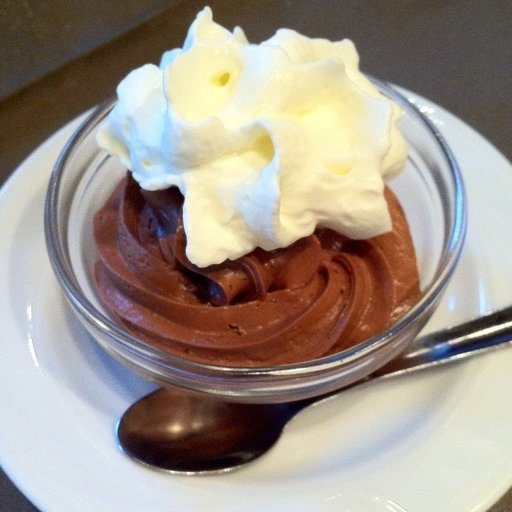

In [17]:
import random
from PIL import Image

# Set seed
# random.seed(99)

# 1. Get all image paths 
# Glob together all of the files that suit a certain pattern
image_path_list   = list(source_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get the image class from path name (the image class is the name of the directory where the image is stored)
image_class       = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class      : {image_class}")
print(f"Image height     : {img.height}")
print(f"Image width      : {img.width}")
img

Text(0.5, 1.0, 'Image class: chocolate_mousse | Image shape: (512, 512, 3) -> [height,width,color_channels] (HWC)')

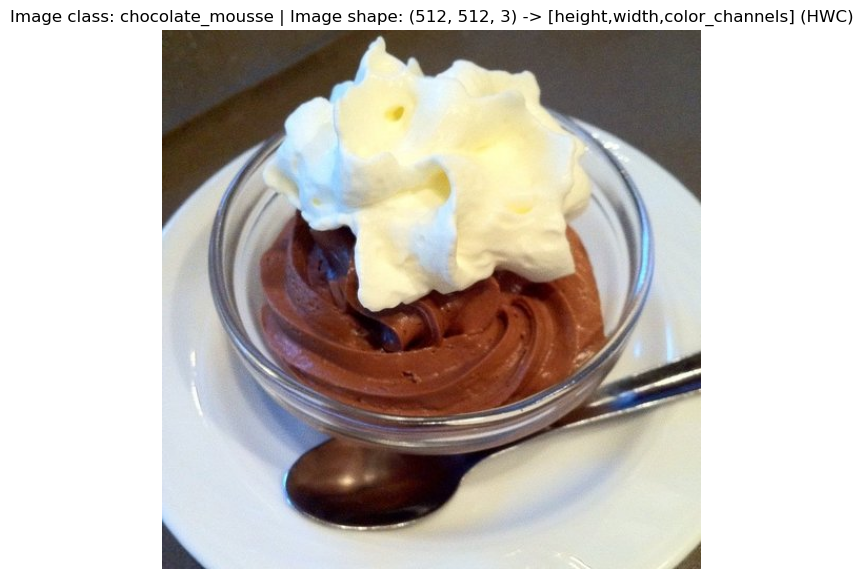

In [18]:
# Visualizing an image with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize = (10,7))
plt.imshow(img_as_array)
plt.axis(False)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height,width,color_channels] (HWC)")

### 3. Transforming Data <a class='anchor' id ='transform'>
    
Before we can use our image data with PyTorch:
1. Turn your target data into tensors(in our case, numerical representation of our images.)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torc.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.


In [19]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### 3.1 Transforming data with `torchvision.transforms`<a class='anchor' id ='torchvision-transform'>
    
Transforms help you get your images ready to be used with a model/perform data augmentation

In [20]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64*64
    transforms.Resize(size            = (64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p = 0.5), # 50% of the time if an image goes through the transform pipeline it will get flipped on the horizontal axis
    # Turn the image into atorch.Tensor
    transforms.ToTensor()
])

In [21]:
data_transform(img).dtype

torch.float32

#### 3.2 Visualizing our Transformed image <a class='anchor' id ='transformed-image'>

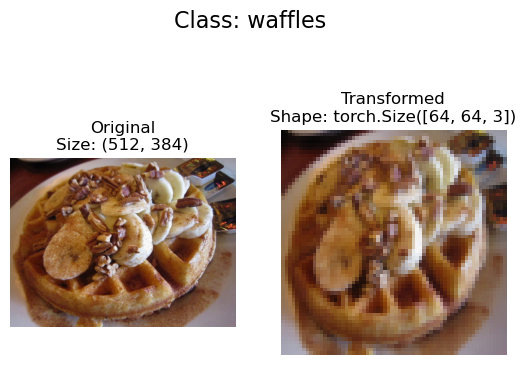

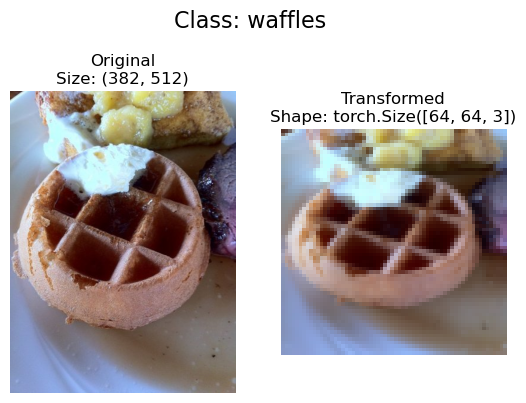

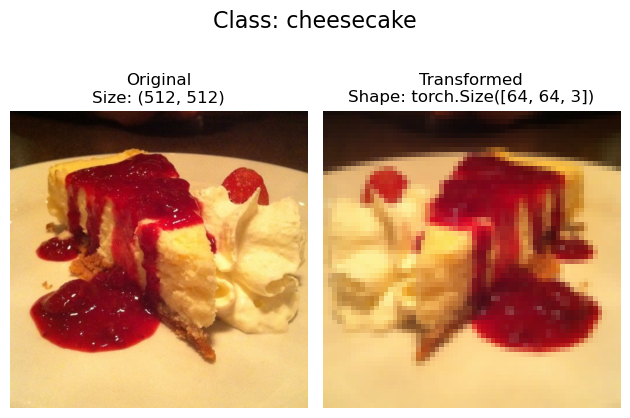

In [22]:
def plot_transformed_images(image_paths: list, transform, n = 3, seed = None):
    """
    Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version. 
    """
    
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k = n)
    
    
    
    for i,image_path in enumerate(random_image_paths):
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)
            
            # Transform and plot target image
            # permute : swap the order of the axis, 
            transformed_image = transform(f).permute(1,2,0) # note we will need to change shape for matplotlib (C,H,W) -> (H,W,C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
    
    plt.tight_layout()
    plt.show()
            
plot_transformed_images(image_paths = image_path_list,
                        transform   = data_transform,
                        n           = 3,
                        seed        = 99)

### 4. Option 1: Loading image data using `ImageFolder` <a class='anchor' id ='load-image'>
    
We can load image classification data using `torchvision.datasets.ImageFolder`

In [23]:
# Use image folder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root             = train_dir,
                                  transform        = data_transform, # transform for the data
                                  target_transform = None) # a transform for the label/target

test_data  = datasets.ImageFolder(root             = test_dir,
                                  transform        = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 3750
     Root location: datas/Chocolates100_percent/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1250
     Root location: datas/Chocolates100_percent/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [24]:
train_dir, test_dir

(PosixPath('datas/Chocolates100_percent/train'),
 PosixPath('datas/Chocolates100_percent/test'))

In [25]:
# Get class names as List
class_names = train_data.classes
class_names

['apple_pie', 'cheesecake', 'chocolate_mousse', 'red_velvet_cake', 'waffles']

In [26]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'apple_pie': 0,
 'cheesecake': 1,
 'chocolate_mousse': 2,
 'red_velvet_cake': 3,
 'waffles': 4}

In [27]:
# Checks the lengths of our dataset
len(train_data), len(test_data)

(3750, 1250)

In [28]:
train_data.samples[0]

('datas/Chocolates100_percent/train/apple_pie/1005649.jpg', 0)

In [29]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor  :\n {img}")
print(f"Image shape   :\n {img.shape}")
print(f"Image datatype:\n {img.dtype}")
print(f"Image label   :\n {label}")
print(f"Label datatype:\n {type(label)}")

Image tensor  :
 tensor([[[0.1922, 0.2196, 0.2745,  ..., 0.1569, 0.1608, 0.1529],
         [0.2588, 0.2863, 0.3451,  ..., 0.2118, 0.2039, 0.1961],
         [0.3686, 0.4000, 0.4078,  ..., 0.2745, 0.2745, 0.2157],
         ...,
         [0.2824, 0.2902, 0.3176,  ..., 0.1843, 0.1922, 0.2078],
         [0.2039, 0.2471, 0.2235,  ..., 0.2078, 0.2039, 0.2000],
         [0.2275, 0.2510, 0.2078,  ..., 0.1882, 0.1765, 0.1765]],

        [[0.2078, 0.2196, 0.2510,  ..., 0.1608, 0.1647, 0.1608],
         [0.2078, 0.2431, 0.3098,  ..., 0.2078, 0.1922, 0.1843],
         [0.3373, 0.3804, 0.4039,  ..., 0.2667, 0.2588, 0.2118],
         ...,
         [0.2431, 0.2510, 0.2863,  ..., 0.1765, 0.1843, 0.1961],
         [0.2078, 0.2431, 0.2196,  ..., 0.1922, 0.1882, 0.1843],
         [0.2196, 0.2275, 0.2157,  ..., 0.1765, 0.1647, 0.1569]],

        [[0.1882, 0.2000, 0.2157,  ..., 0.1451, 0.1569, 0.1412],
         [0.1843, 0.2275, 0.2863,  ..., 0.2118, 0.1843, 0.1725],
         [0.3255, 0.3686, 0.3882,  ..., 0

Original shape: torch.Size([3, 64, 64])         -> [color_channels, height, width]
Image permute : torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'apple_pie')

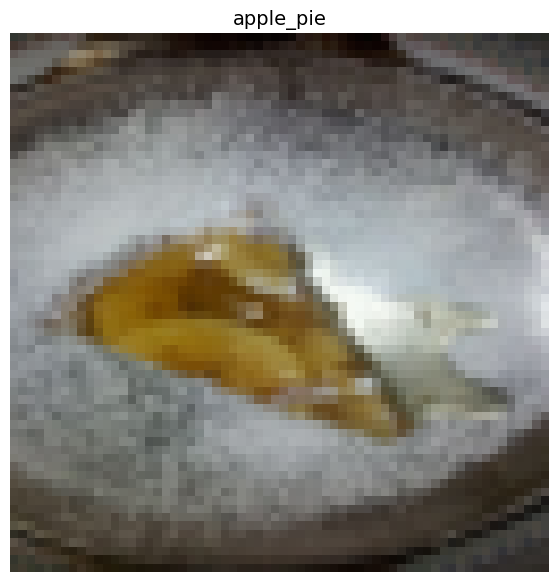

In [30]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original shape: {img.shape}         -> [color_channels, height, width]")
print(f"Image permute : {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize = (10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize = 14)

#### 4.1 Turn loaded images into `DataLoader's`  <a class='anchor' id ='dataloader'>
    
A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [31]:
import os
os.cpu_count()

8

In [32]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset    = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers= os.cpu_count(), # count how many CPUs your compute hardware has
                              shuffle    = True)

test_dataloader  = DataLoader(dataset    = test_data,
                              batch_size = BATCH_SIZE,
                              num_workers= os.cpu_count(),
                              shuffle    = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x138b4a1d0>,
 <torch.utils.data.dataloader.DataLoader at 0x138b61e50>)

In [33]:
len(train_dataloader) , len(test_dataloader)

(118, 40)

In [34]:
len(train_data) , len(test_data)

(3750, 1250)

In [35]:
# Iterating through our train_dataloader
img, label = next(iter(train_dataloader))

# Wihin each batch we have 32 images and 32 labels
print(f"Image shape: {img.shape}   -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64])   -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


### 5. Option 2: Loading Image Data with a Custom `Dataset` <a class='anchor' id ='load_customdataset'>

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset
    
Pros :
    
    * Can create a `Dataset` out of almost anything
    * Not limited to PyTorch pre-build `Dataset` functions
    
Cons:
    
    * Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
    * Using a custom `Dataset` often results in us writing more code, which could be prone to erros or performance issues.
    

In [36]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [37]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['apple_pie', 'cheesecake', 'chocolate_mousse', 'red_velvet_cake', 'waffles'],
 {'apple_pie': 0,
  'cheesecake': 1,
  'chocolate_mousse': 2,
  'red_velvet_cake': 3,
  'waffles': 4})

#### 5.1 Creating a helper function to get class names <a class='anchor' id ='helper_function'>
    
We want a function to:
    
    1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format (train/test)).
    2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure.)
    3. Turn the class names into a dict and a list and return them.

In [38]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: datas/Chocolates100_percent/train


['apple_pie', 'cheesecake', 'chocolate_mousse', 'red_velvet_cake', 'waffles']

In [39]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]: 
    """
    Find the class folder names in a target directory.
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}...please check file structure.")
    
    # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    
    return classes, class_to_idx

In [40]:
find_classes(target_directory)

(['apple_pie', 'cheesecake', 'chocolate_mousse', 'red_velvet_cake', 'waffles'],
 {'apple_pie': 0,
  'cheesecake': 1,
  'chocolate_mousse': 2,
  'red_velvet_cake': 3,
  'waffles': 4})

#### 5.2 Create a custom `Dataset` to replicate `ImageFolder` <a class='anchor' id ='replicate-imagefolder'>
    
To create our own custom dataset, we want to:
    
    1. Subclass `torch.utils.data.Dataset`
    2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
    3. Create several attributes:
        * paths        : paths of our images
        * transform    : the transform we'd like to use
        * classes      : a list of the target classes
        * class_to_idx : a dict of the target classes mapped to integer labels.
    4. Create a function to `load_images()`, this function will open an image
    5. Overwrite the `__len()__` method to return the length of our dataset
    6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [41]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, 
                 targ_dir  : str, 
                 transform = None):
        # 3. Create class attributes
        # Get all of the image paths
        self.paths     = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes , self.class_to_idx = find_classes(targ_dir)
        
    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via path and returns it"
        image_path     = self.paths[index] 
        return Image.open(image_path)
    
    # 5. Overwrite __len__()
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite __getitem__() method to return a particular sample
    # getitem() replicates this -> img, label = train_data[0]
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X,y)."
        img            = self.load_image(index)
        class_name     = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
        class_idx      = self.class_to_idx[class_name]
        
        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label(X,y)
        else:
            return img, class_idx # return untransformed image and label
         

In [42]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
                                        transforms.Resize(size = (64,64)),
                                        transforms.RandomHorizontalFlip(p = 0.5),
                                        transforms.ToTensor()  
])

test_transforms  = transforms.Compose([
                                        transforms.Resize(size = (64,64)),
                                        transforms.ToTensor()  
])

In [43]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir  = train_dir,
                                      transform = train_transforms)
 
test_data_custom  = ImageFolderCustom(targ_dir  = test_dir,
                                      transform = test_transforms)

In [44]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x138a094d0>,
 <__main__.ImageFolderCustom at 0x138b70310>)

In [45]:
len(train_data) , len(train_data_custom)

(3750, 3750)

In [46]:
len(test_data) ,  len(test_data_custom) 

(1250, 1250)

In [47]:
train_data_custom.classes

['apple_pie', 'cheesecake', 'chocolate_mousse', 'red_velvet_cake', 'waffles']

In [48]:
train_data_custom.class_to_idx

{'apple_pie': 0,
 'cheesecake': 1,
 'chocolate_mousse': 2,
 'red_velvet_cake': 3,
 'waffles': 4}

In [49]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes  == test_data.classes)

True
True


#### 5.3 Create a function to display random images  <a class='anchor' id ='display-images'>
    
1.  Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)
    

In [50]:
# 1. Create a function to take in a dataset
def display_random_images(dataset       : torch.utils.data.Dataset,
                          classes       : List[str] = None,
                          n             : int       = 10,
                          display_shape : bool      = True,
                          seed          : int       = None):
    # 2. Adjust display if n is too high
    if n>10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
        
    # 3. Set the seed
    if seed:
        random.seed(seed)
        
    # 4. Get random sample indexes
    random_sample_idx  = random.sample(range(len(dataset)), k = n)
    
    # 5. Setup plot
    plt.figure(figsize = (16,8))
    
    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_sample_idx):
        targ_image , targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        
        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1,2,0) # [color_channel,height,width] -> [height, width, color_channels]
    
        # Plot adjusted samples
        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class : {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape:{targ_image_adjust.shape}"
            plt.title(title)

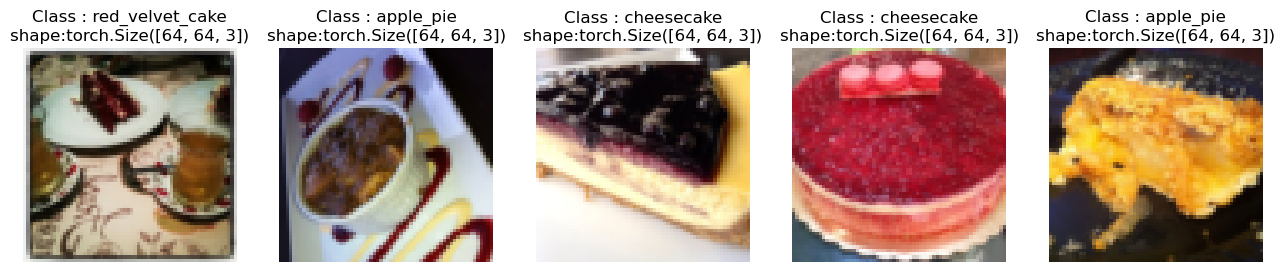

In [51]:
# Display random images from the imageFolder created Dataset
display_random_images(train_data,
                      n       = 5,
                      classes = class_names,
                      seed    = None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


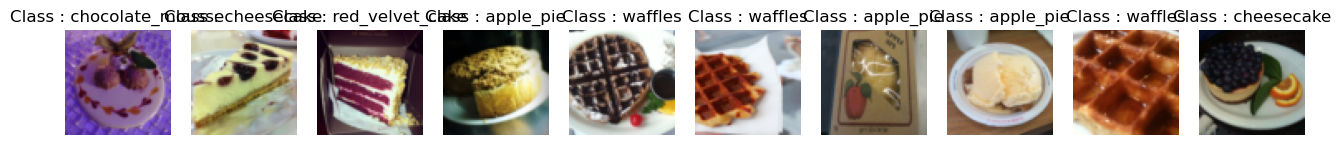

In [52]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n       = 20,
                      classes = class_names,
                      seed    = None)

#### 5.4 Turn custom loaded images into `DataLoader`'s <a class='anchor' id ='custom-dataloader'>
    

In [53]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset    = train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers= 0,
                                     shuffle    = True)

test_dataloader_custom  = DataLoader(dataset    = test_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers= 0,
                                     shuffle    = False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x138fddcd0>,
 <torch.utils.data.dataloader.DataLoader at 0x1388f7890>)

In [54]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### 6. Other forms of transforms (Data Augmentation)   <a class='anchor' id ='augmentation'>
    
Data Augmentation is the process of artificially adding diversity to your training data.
    
In the case of image data, this may mean applying various image transformations to the training images.
    
This practice results in a model that's more generalizable to unseen data.
    
Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...

![Data Augmentation](custom3.png)

In [55]:
# Let's look at trivial augment

from torchvision import transforms

train_transform = transforms.Compose([
                                        transforms.Resize(size = (224,224)),
                                       # how intense you want your augmentation to happen
                                        transforms.TrivialAugmentWide(num_magnitude_bins = 31),
                                        transforms.ToTensor()
])

test_transform  = transforms.Compose([
                                        transforms.Resize(size = (224,224)),
                                        transforms.ToTensor()
])

In [56]:
source_path

PosixPath('datas/Chocolates100_percent')

In [57]:
# Get all image paths
image_path_list = list(source_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('datas/Chocolates100_percent/test/cheesecake/177866.jpg'),
 PosixPath('datas/Chocolates100_percent/test/cheesecake/2398894.jpg'),
 PosixPath('datas/Chocolates100_percent/test/cheesecake/2079422.jpg'),
 PosixPath('datas/Chocolates100_percent/test/cheesecake/3837391.jpg'),
 PosixPath('datas/Chocolates100_percent/test/cheesecake/181706.jpg'),
 PosixPath('datas/Chocolates100_percent/test/cheesecake/2230878.jpg'),
 PosixPath('datas/Chocolates100_percent/test/cheesecake/2585042.jpg'),
 PosixPath('datas/Chocolates100_percent/test/cheesecake/2956877.jpg'),
 PosixPath('datas/Chocolates100_percent/test/cheesecake/280106.jpg'),
 PosixPath('datas/Chocolates100_percent/test/cheesecake/1374014.jpg')]

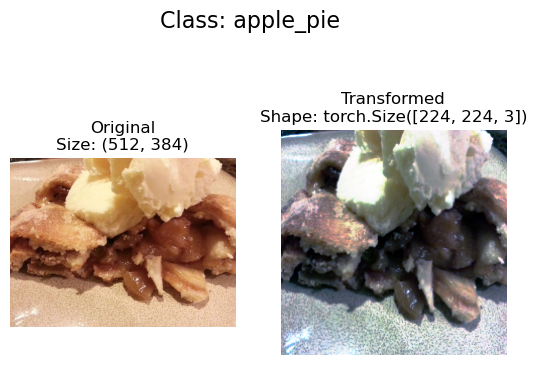

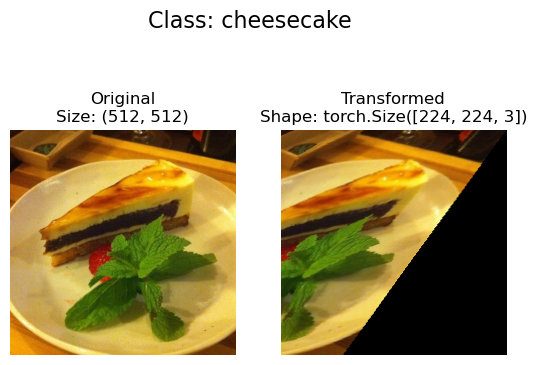

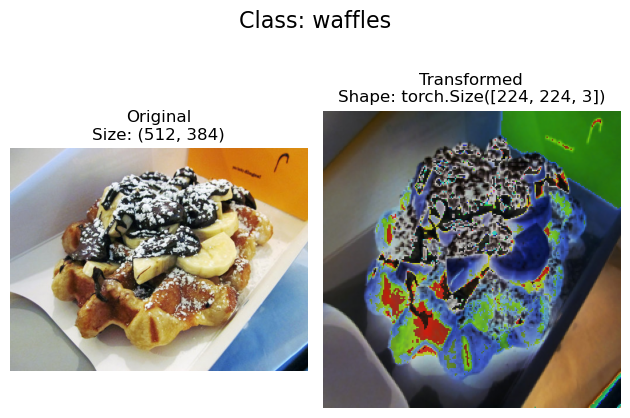

In [58]:
# Plot random transformed images
plot_transformed_images(
        image_paths = image_path_list,
        transform   = train_transform,
        n           = 3,
        seed        = None
)

### 7. Model 0 : TinyVGG without Data Augmentation <a class='anchor' id ='model-0'>
    
Let's replicate the TinyVGG architecture from the CNN explainer website.

#### 7.1 Creating transforms and loading data for Model 0 <a class='anchor' id ='load-model-0'>

In [59]:
# Create simple transform
simple_transform = transforms.Compose([
                                        transforms.Resize(size = (64,64)),
                                        transforms.ToTensor()
])

In [60]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root      = train_dir,
                                         transform = simple_transform)

test_data_simple  = datasets.ImageFolder(root      = test_dir,
                                         transform = simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# 3. Setup batch size and number of works
BATCH_SIZE  = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple  = DataLoader(dataset    = train_data_simple,
                                      batch_size = BATCH_SIZE,
                                      shuffle    = True,
                                      num_workers= NUM_WORKERS)

test_dataloader_simple   = DataLoader(dataset    = test_data_simple,
                                      batch_size = BATCH_SIZE,
                                      shuffle    = False,
                                      num_workers= NUM_WORKERS)


#### 7.2 Create TinyVGG Model Class <a class='anchor' id ='create-model-0'>

In [61]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TingVGG from CNN Explainer
    """
    def __init__(self, input_shape  : int,
                 hidden_units       : int,
                 output_shape       : int
                ) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels   = input_shape,
                      out_channels  = hidden_units,
                      kernel_size   = 3,
                      stride        = 1,
                      padding       = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels   = hidden_units,
                      out_channels  = hidden_units,
                      kernel_size   = 3,
                      stride        = 1,
                      padding       = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2,
                         stride     = 2) # default stride value is same as kernel size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels   = hidden_units,
                      out_channels  = hidden_units,
                      kernel_size   = 3,
                      stride        = 1,
                      padding       = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels   = hidden_units,
                      out_channels  = hidden_units,
                      kernel_size   = 3,
                      stride        = 1,
                      padding       = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2,
                         stride     = 2) # default stride value is same as kernel size
        )
        self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(in_features = hidden_units*13*13,
                          out_features= output_shape)
        )
        
    def forward(self, x):
        x = self.conv_block_1(x)
#         print(x.shape)
        x = self.conv_block_2(x)
#         print(x.shape)
        x = self.classifier(x)
#         print(x.shape)
        return x
#            return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefit from operator fusion
        

In [62]:
torch.manual_seed(99)
model_0 = TinyVGG(input_shape = 3, # number of color channels in our image data
                  hidden_units= 10,
                  output_shape= len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=5, bias=True)
  )
)

#### 7.3 Try a forward pass on a single image (to test the model) <a class='anchor' id ='forwardpass'>

In [63]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [64]:
# Try a Forward Pass
model_0(image_batch)

tensor([[ 2.3081e-02, -1.3263e-02, -1.7681e-03, -7.1077e-03, -3.7205e-02],
        [ 2.6614e-02, -1.4536e-02,  1.3291e-03, -3.2390e-03, -3.8603e-02],
        [ 1.7302e-02, -2.3111e-02, -5.0742e-03,  4.0030e-03, -3.7393e-02],
        [ 2.6831e-02, -1.2336e-02, -3.6946e-03, -5.7552e-03, -3.0320e-02],
        [ 2.4485e-02, -7.1853e-03, -4.2259e-03, -9.6237e-03, -3.9758e-02],
        [ 2.5078e-02, -1.3513e-02, -2.5605e-03,  2.2993e-03, -3.5857e-02],
        [ 2.5074e-02, -8.2116e-03,  1.2490e-03, -9.3608e-03, -4.0167e-02],
        [ 2.0834e-02, -1.7913e-02, -5.3674e-03, -8.1201e-04, -3.9000e-02],
        [ 2.6215e-02, -1.3225e-02, -5.4748e-03, -5.2864e-03, -3.4718e-02],
        [ 2.3803e-02, -1.1043e-02,  3.9261e-03, -4.1115e-04, -4.6277e-02],
        [ 2.0833e-02, -1.3388e-02,  4.6367e-03,  1.2785e-04, -4.4271e-02],
        [ 2.5811e-02, -1.5698e-02, -4.6060e-03, -7.1144e-03, -2.6940e-02],
        [ 2.4487e-02, -1.5785e-02, -5.3573e-03, -4.5977e-03, -3.2068e-02],
        [ 2.1979e-02, -2.

#### 7.4 Use `torchinfo` to get an idea of the shapes going through our model <a class='anchor' id ='torchinfo'>

In [65]:
import torchinfo
from torchinfo import summary
summary(model_0, input_size = (1,3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 5]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

#### 7.5 Creating train and test loop functions <a class='anchor' id ='loop'>
    
    * `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
    * `test_step()`  - takes in a model and dataloader and evaluates the model on the dataloader.

In [66]:
# Create train_step()
def train_step(model      : torch.nn.Module,
               dataloader : torch.utils.data.DataLoader,
               loss_fn    : torch.nn.Module,
               optimizer  : torch.optim.Optimizer,
               device     = device):
    # Put the model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0,0
    
    # Loop through data loader data batches
    for batch, (X,y) in enumerate(dataloader):
        # Send data to the target device
        X,y    = X.to(device), y.to(device)
        
        # 1. Forward Pass
        y_pred = model(X) # output model logits
        
        # 2. Calculate the loss
        loss        = loss_fn(y_pred,y)
        train_loss += loss.item()
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
        # 6. Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
        train_acc   += (y_pred_class==y).sum().item()/len(y_pred)
        
    # Adjust metrics to get the average loss and accuracy per batch
    train_loss       = train_loss / len(dataloader)
    train_acc        = train_acc  / len(dataloader)
    return train_loss, train_acc
        

In [67]:
# Create a test step
def test_step(model      : torch.nn.Module,
              dataloader : torch.utils.data.DataLoader,
              loss_fn    : torch.nn.Module,
              device     = device):
    # Put model in eval mode
    model.eval()
    
    # Setup test loss and test accuracy values
    test_loss, test_acc  = 0, 0
    
    # Turn on inference mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X,y) in enumerate(dataloader):
            # Send data to the target device
            X,y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred_logits = model(X)
            
            # 2. Calculate the loss
            loss             = loss_fn(test_pred_logits,y)
            test_loss       += loss.item()
            
            # Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim = 1)
            test_acc        += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
        # Adjust metrics to get average loss and accuracy per batch
        test_loss            = test_loss / len(dataloader)
        test_acc             = test_acc  / len(dataloader)
        return test_loss, test_acc

#### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()` <a class='anchor' id ='train()'>

In [68]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model             : torch.nn.Module,
          train_dataloader  : torch.utils.data.DataLoader,
          test_dataloader   : torch.utils.data.DataLoader,
          optimizer         : torch.optim.Optimizer,
          loss_fn           : torch.nn.Module = nn.CrossEntropyLoss(),
          epochs            : int = 5,
          device            = device):
    # 2. Create empty results dictionary
    results = {"train_loss" : [],
               "train_acc"  : [],
               "test_loss"  : [],
               "test_acc"   : []}
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model      = model,
                                           dataloader = train_dataloader,
                                           loss_fn    = loss_fn,
                                           optimizer  = optimizer,
                                           device     = device)
        
        test_loss,  test_acc = test_step(model       = model,
                                          dataloader  = test_dataloader,
                                          loss_fn     = loss_fn,
                                          device      = device)
        
        # 4. Print out what's happenin'
        print(f"Epoch: {epoch} | Train loss: {train_loss: .4f} | Train acc: {train_acc : .4f} | Test loss: {test_loss: .4f} | Test acc: {test_acc:.4f}")
        
        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    # 6. Return the filled results at the end of the epochs
    return results

#### 7.7 Train and evaluate model 0 <a class='anchor' id ='evaluate-model0'>

In [69]:
# Set random seed
torch.manual_seed(99)
torch.cuda.manual_seed(99)

# Set number of epochs
NUM_EPOCHS = 7

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape  = 3, # number of color channels of our target images
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr     = 0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0
model_0_results = train(model            = model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader  = test_dataloader_simple,
                        optimizer        = optimizer,
                        loss_fn          = loss_fn,
                        epochs           = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()

print(f"Total training time: {end_time - start_time: .3f} seconds")

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 0 | Train loss:  1.5653 | Train acc:  0.2684 | Test loss:  1.4731 | Test acc: 0.3656
Epoch: 1 | Train loss:  1.4437 | Train acc:  0.3832 | Test loss:  1.4099 | Test acc: 0.3898
Epoch: 2 | Train loss:  1.3609 | Train acc:  0.4289 | Test loss:  1.2936 | Test acc: 0.4578
Epoch: 3 | Train loss:  1.3253 | Train acc:  0.4529 | Test loss:  1.2539 | Test acc: 0.4734
Epoch: 4 | Train loss:  1.2708 | Train acc:  0.4748 | Test loss:  1.2283 | Test acc: 0.4953
Epoch: 5 | Train loss:  1.2368 | Train acc:  0.4893 | Test loss:  1.1907 | Test acc: 0.4984
Epoch: 6 | Train loss:  1.2034 | Train acc:  0.5154 | Test loss:  1.2032 | Test acc: 0.5000
Total training time:  738.177 seconds


In [70]:
model_0_results

{'train_loss': [1.5653152283975633,
  1.4437318161382513,
  1.3609487424462527,
  1.3253071712235274,
  1.270828706733251,
  1.2368316049292936,
  1.2033966850426236],
 'train_acc': [0.2684498587570621,
  0.3832097457627119,
  0.4289371468926554,
  0.4528601694915254,
  0.4747528248587571,
  0.4893185028248588,
  0.5153601694915254],
 'test_loss': [1.473095679283142,
  1.4099299281835556,
  1.293562176823616,
  1.2539191126823426,
  1.2282749965786934,
  1.190669296681881,
  1.2032223507761954],
 'test_acc': [0.365625,
  0.38984375,
  0.4578125,
  0.4734375,
  0.4953125,
  0.4984375,
  0.5]}

In [71]:
class ImprovedTinyVGG(nn.Module):
    """
    Improved version of the TinyVGG model architecture
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1          = nn.Sequential(
            nn.Conv2d(in_channels  =  input_shape, 
                                      out_channels = 32, 
                                      kernel_size  = 3, 
                                      padding      = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels  = 32, 
                      out_channels = 64, 
                      kernel_size  = 3, 
                      padding      = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels  = 64, 
                      out_channels = 128, 
                      kernel_size  = 3, 
                      padding      = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels    = 128, 
                      out_channels   = 128, 
                      kernel_size    = 3, 
                      padding        = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, 
                         stride      = 2)
        )
        self.fc_layers               = nn.Sequential(
            nn.Linear(in_features    = 32768, 
                      out_features   = 512),  # Adjusted the input size to match the flattened size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features    = 512, 
                      out_features   = output_shape)
)


    def forward(self, x):
        x = self.conv_block_1(x)
#         print(x.shape)
        x = self.conv_block_2(x)
#         print(x.shape)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
#         print(x.shape)
        x = self.fc_layers(x)
#         print(x.shape)
        return x
    
    



In [72]:
model_2 = ImprovedTinyVGG(input_shape = 3, # number of color channels in our image data
                          hidden_units= 10,
                          output_shape= len(class_names)).to(device)
model_2

ImprovedTinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequenti

In [73]:
# Set random seed
torch.manual_seed(99)
torch.cuda.manual_seed(99)

# Set number of epochs
NUM_EPOCHS = 10


# Setup loss function and optimizer
loss_fn    = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train the model
model_2_results = train(model           = model_2,
                      train_dataloader  = train_dataloader_simple,
                      test_dataloader   = test_dataloader_simple,
                      optimizer         = optimizer,
                      loss_fn           = loss_fn,
                      epochs            = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()

print(f"Total training time: {end_time - start_time:.3f} seconds")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss:  3.1623 | Train acc:  0.2480 | Test loss:  1.5112 | Test acc: 0.3555
Epoch: 1 | Train loss:  1.4854 | Train acc:  0.3528 | Test loss:  1.3705 | Test acc: 0.3945
Epoch: 2 | Train loss:  1.4396 | Train acc:  0.3715 | Test loss:  1.4074 | Test acc: 0.3984
Epoch: 3 | Train loss:  1.4279 | Train acc:  0.3633 | Test loss:  1.3239 | Test acc: 0.4109
Epoch: 4 | Train loss:  1.3973 | Train acc:  0.3853 | Test loss:  1.2538 | Test acc: 0.4648
Epoch: 5 | Train loss:  1.3785 | Train acc:  0.4072 | Test loss:  1.2887 | Test acc: 0.4672
Epoch: 6 | Train loss:  1.3455 | Train acc:  0.4128 | Test loss:  1.2451 | Test acc: 0.4898
Epoch: 7 | Train loss:  1.3192 | Train acc:  0.4431 | Test loss:  1.2099 | Test acc: 0.5102
Epoch: 8 | Train loss:  1.3096 | Train acc:  0.4418 | Test loss:  1.1775 | Test acc: 0.5211
Epoch: 9 | Train loss:  1.2829 | Train acc:  0.4632 | Test loss:  1.1943 | Test acc: 0.5367
Total training time: 1715.788 seconds


In [74]:
model_2_results

{'train_loss': [3.1622604596412787,
  1.4854304255065272,
  1.4395852695077151,
  1.4278974916975378,
  1.3973417453846688,
  1.3785320833577948,
  1.345471264447196,
  1.3192324294882305,
  1.309567815671533,
  1.2829268362562536],
 'train_acc': [0.2479696327683616,
  0.3527542372881356,
  0.37146892655367236,
  0.3633474576271186,
  0.3853283898305085,
  0.4072210451977401,
  0.41278248587570626,
  0.4430614406779661,
  0.4418255649717514,
  0.4631885593220339],
 'test_loss': [1.511187356710434,
  1.3705244034528732,
  1.4074141010642052,
  1.3238707959651947,
  1.253834429383278,
  1.288740372657776,
  1.2450622916221619,
  1.209927996993065,
  1.177492582798004,
  1.1943179324269295],
 'test_acc': [0.35546875,
  0.39453125,
  0.3984375,
  0.4109375,
  0.46484375,
  0.4671875,
  0.48984375,
  0.51015625,
  0.52109375,
  0.53671875]}

#### 7.8 Plot the loss curves of Model 0   <a class='anchor' id ='plot-model0'>
    
* A **loss curve** is a way of tracking your model's progress over time.
    

In [75]:
# Get the model_0 results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [76]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary."""
    
    # Get the loss values of the results dictionary (training and test)
    loss          = results["train_loss"]
    test_loss     = results["test_loss"]
    
    # Get the accuracy values of the results dictionary (training and test)
    accuracy      = results["train_acc"]
    test_accuracy = results["test_acc"]
    
    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))
    
    # Setup a plot
    plt.figure(figsize = (15,7))
    
    # Plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss,       label = "train_loss")
    plt.plot(epochs, test_loss , label = "test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    # Plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy,     label = "train_accuracy")
    plt.plot(epochs,test_accuracy, label = "test_accuracy")
    plt.title("Accuracy")
    plt.ylabel("Epochs")
    plt.legend()

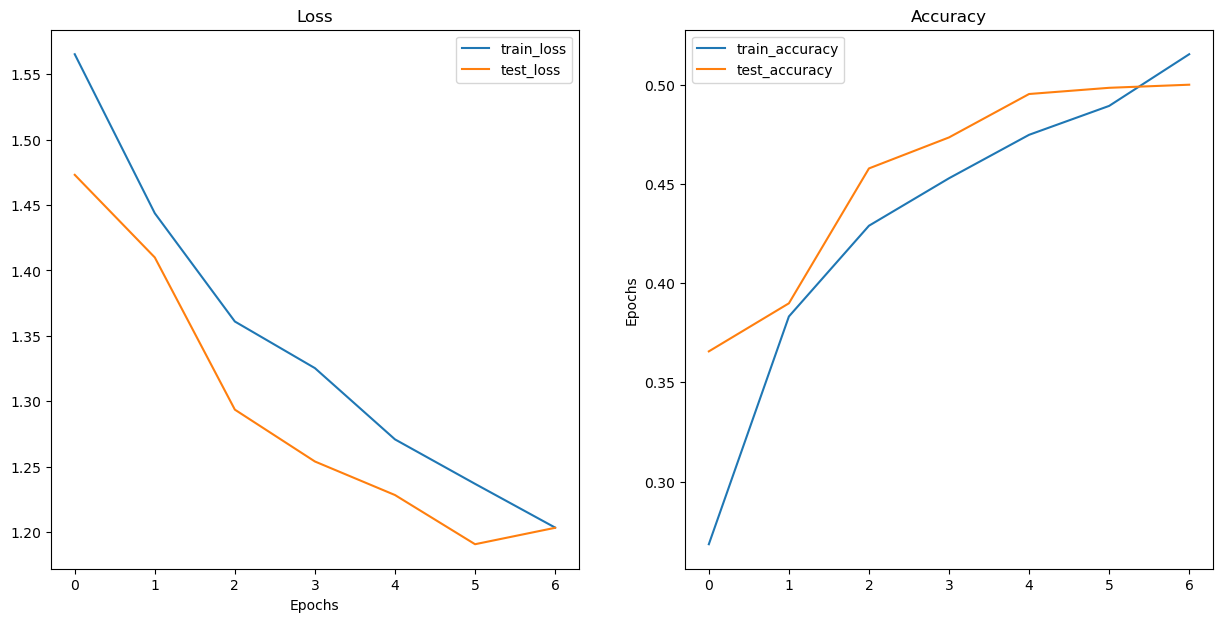

In [77]:
plot_loss_curves(model_0_results)

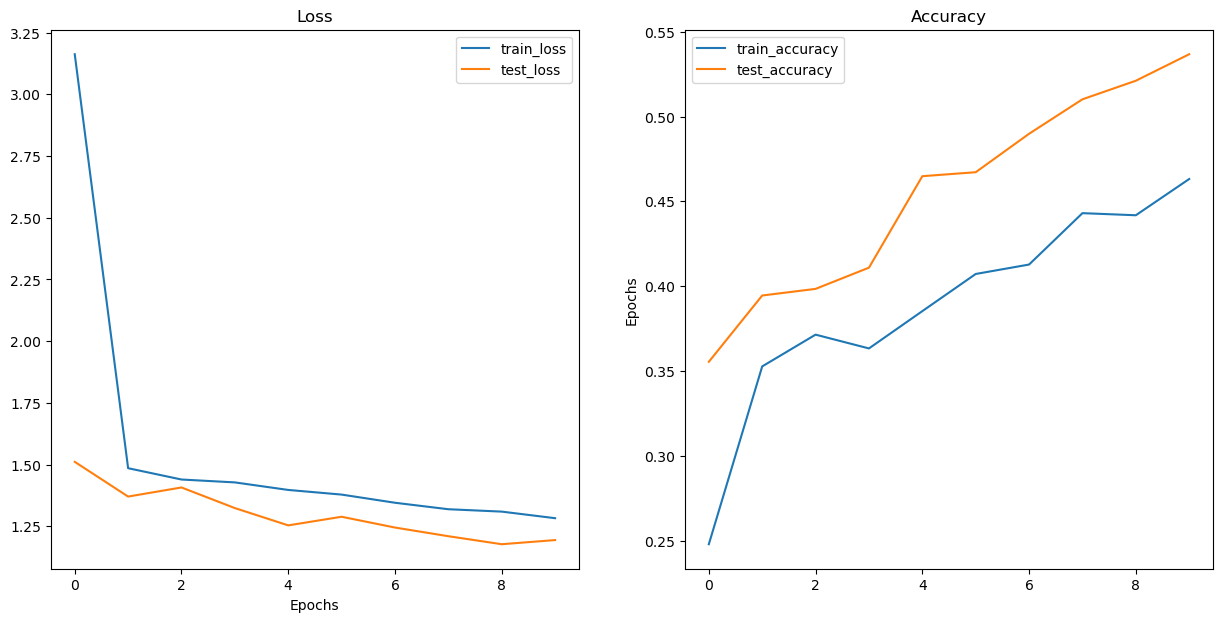

In [78]:
plot_loss_curves(model_2_results)

### 8. What should an ideal loss curve look like?  <a class='anchor' id ='ideal-curve'>

A loss curve is one of the most helpful ways to troubleshoot a model.

![Loss Curves](custom4.png)
![Overfitting](custom5.png)
![Underfitting](custom6.png)

#### Early Stopping
![Early Stopping](custom7.png)

### 9. Model 1: TingVGG with Data Augmentation  <a class='anchor' id ='model1'>

Trying another modelling experiment using the same model as before with some slight data augmentation.

#### 9.1 Create transform with data augmentation  <a class='anchor' id ='model1-transform'>

In [79]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
                                                transforms.Resize(size = (64,64)),
                                                transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                                transforms.ToTensor()
])

test_transform_simple   = transforms.Compose([
                                                transforms.Resize(size = (64,64)),
                                                transforms.ToTensor()
]) 

#### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with Data Augmentation <a class='anchor' id ='model1-dataloader'>

In [80]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented    = datasets.ImageFolder(root      = train_dir,
                                               transform = train_transform_trivial)

test_data_simple        = datasets.ImageFolder(root      = test_dir,
                                               transform = test_transform_simple)


In [81]:
# Turn our datasets into DataLoaders
import os

from torch.utils.data import DataLoader
BATCH_SIZE  = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(99)
train_dataloader_augmented = DataLoader(dataset    = train_data_augmented,
                                        batch_size = BATCH_SIZE,
                                        shuffle    = True,
                                        num_workers= NUM_WORKERS)

test_dataloader_simple     = DataLoader(dataset    = test_data_simple,
                                        batch_size = BATCH_SIZE,
                                        shuffle    = False,
                                        num_workers= NUM_WORKERS)

#### 9.3 Construct and train Model 1 <a class='anchor' id ='model1-construct'>
    
We will be using the same model architecture except this time we've augmented the training data.

In [82]:
# Create model_1 and send it to the target device
torch.manual_seed(99)
model_1  = TinyVGG(input_shape  = 3,
                   hidden_units = 10,
                   output_shape = len(train_data_augmented.classes)
                  ).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=5, bias=True)
  )
)

In [90]:
# Create a loss function and optimizer and call upon our `train()` function to train and evaluate our model

# Set random seed
torch.manual_seed(99)
torch.cuda.manual_seed(99)

# Set the number of epochs 
NUM_EPOCHS = 7

# Set up loss function
loss_fn    = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(params = model_1.parameters(),
                              lr     = 0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results = train(model            = model_1,
                        train_dataloader = train_dataloader_augmented,
                        test_dataloader  = test_dataloader_simple,
                        optimizer        = optimizer,
                        loss_fn          = loss_fn,
                        epochs           = NUM_EPOCHS,
                        device           = device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 0 | Train loss:  1.3821 | Train acc:  0.4246 | Test loss:  1.2549 | Test acc: 0.4805
Epoch: 1 | Train loss:  1.3685 | Train acc:  0.4245 | Test loss:  1.2782 | Test acc: 0.4469
Epoch: 2 | Train loss:  1.3421 | Train acc:  0.4388 | Test loss:  1.2057 | Test acc: 0.4969
Epoch: 3 | Train loss:  1.3373 | Train acc:  0.4373 | Test loss:  1.2412 | Test acc: 0.4766
Epoch: 4 | Train loss:  1.3351 | Train acc:  0.4290 | Test loss:  1.2267 | Test acc: 0.4789
Epoch: 5 | Train loss:  1.3102 | Train acc:  0.4596 | Test loss:  1.1440 | Test acc: 0.5328
Epoch: 6 | Train loss:  1.3161 | Train acc:  0.4597 | Test loss:  1.1769 | Test acc: 0.4953
Total training time for model_1: 758.997 seconds


In [91]:
model_1_results

{'train_loss': [1.382089488587137,
  1.368452096389512,
  1.342127197879856,
  1.3372659410460521,
  1.3351053676362765,
  1.3101777777833454,
  1.3160647982257907],
 'train_acc': [0.4246115819209039,
  0.4245233050847458,
  0.4388241525423729,
  0.4373234463276836,
  0.4290254237288136,
  0.459569209039548,
  0.45965748587570626],
 'test_loss': [1.2548763379454613,
  1.2781615659594536,
  1.2056645646691322,
  1.241197220981121,
  1.2267271116375924,
  1.1439520448446274,
  1.1769074201583862],
 'test_acc': [0.48046875,
  0.446875,
  0.496875,
  0.4765625,
  0.47890625,
  0.5328125,
  0.4953125]}

#### 9.4 Plot the loss curves of model 1<a class='anchor' id ='model1-plot'>
    
A loss curve helps you evaluate your models performance overtime.

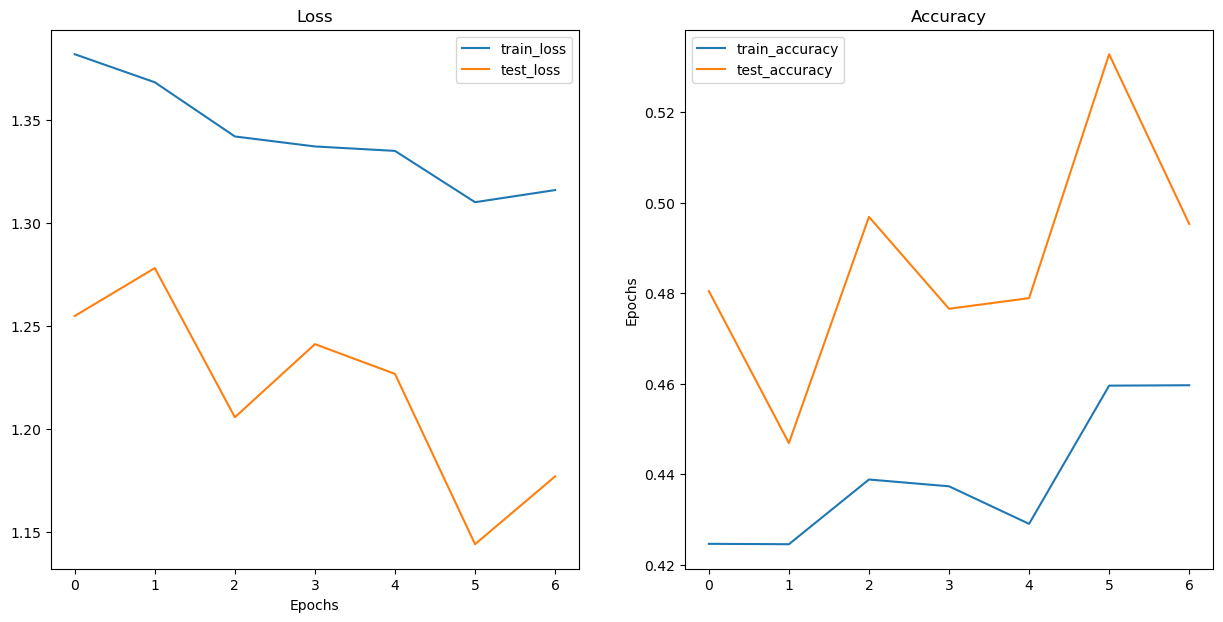

In [92]:
plot_loss_curves(model_1_results)

### 10. Compare model results <a class='anchor' id ='model_result'>
    
After evaluating our modelling experiments on their own, it's important to compare them to each other.
    
There's a few different ways to do this:
    
    1. Hard Coding (what we're doing)
    2. PyTorch + Tensorboard
    3. Weights & Biases
    4. MLFlow
    

In [93]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.565315   0.268450   1.473096  0.365625
1    1.443732   0.383210   1.409930  0.389844
2    1.360949   0.428937   1.293562  0.457813
3    1.325307   0.452860   1.253919  0.473438
4    1.270829   0.474753   1.228275  0.495312
5    1.236832   0.489319   1.190669  0.498437
6    1.203397   0.515360   1.203222  0.500000

In [94]:
epochs_model_0 = range(len(model_0_df["train_loss"]))
epochs_model_1 = range(len(model_1_df["train_loss"]))

In [95]:
epochs_model_0 , epochs_model_1

(range(0, 7), range(0, 7))

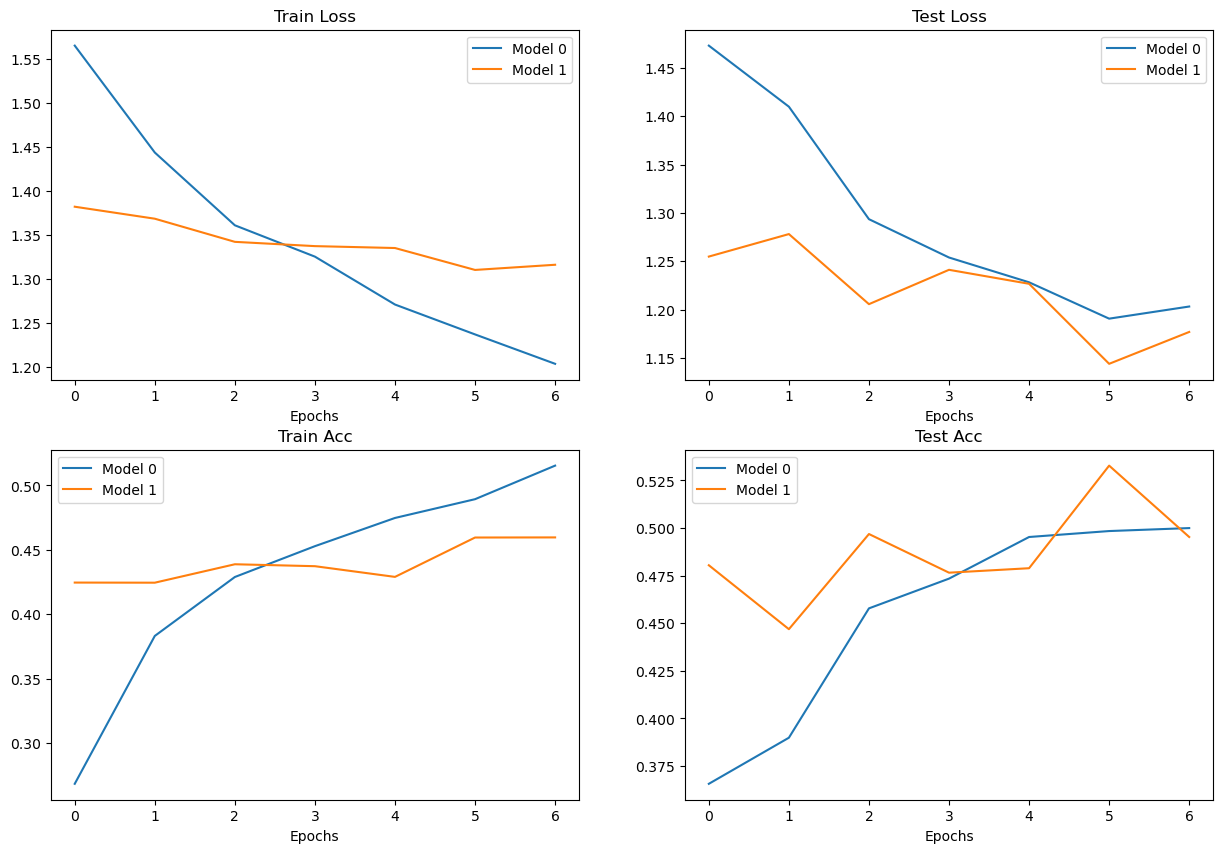

In [96]:
# Setup a plot
plt.figure(figsize = (15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend()


### 11. Making a prediction on a custom image  <a class='anchor' id ='prediction'>
    
Although we have trained our model on custom data... how do you make a prediction on a sample/image that's not in either training or testing dataset.

In [97]:
source_path

PosixPath('datas/Chocolates100_percent')

In [98]:
# Setup custom image path
custom_image_path = source_path / "04-waffle.jpeg"

In [99]:
custom_image_path

PosixPath('datas/Chocolates100_percent/04-waffle.jpeg')

#### 11.1 Loading in a custom image with PyTorch <a class='anchor' id ='customimage'>
    
We have to make sure our custom image is in the same format as the data our model was trained on.
    
    * In tensor form with datatype (torch.float32)
    * Of shape 64*64*3
    * On the right device

In [101]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape :\n {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[196, 195, 192,  ..., 135, 134, 134],
         [195, 193, 191,  ..., 135, 134, 134],
         [192, 191, 189,  ..., 135, 134, 134],
         ...,
         [236, 226, 206,  ..., 154, 162, 155],
         [235, 232, 207,  ..., 169, 167, 159],
         [232, 239, 211,  ..., 175, 174, 164]],

        [[213, 212, 209,  ..., 177, 176, 176],
         [212, 210, 208,  ..., 177, 176, 176],
         [209, 208, 206,  ..., 177, 176, 176],
         ...,
         [232, 222, 201,  ..., 150, 172, 175],
         [231, 228, 202,  ..., 169, 181, 184],
         [228, 235, 206,  ..., 178, 189, 193]],

        [[203, 202, 199,  ..., 175, 174, 174],
         [202, 200, 198,  ..., 175, 174, 174],
         [199, 198, 196,  ..., 175, 174, 174],
         ...,
         [231, 219, 195,  ..., 121, 147, 150],
         [230, 225, 196,  ..., 143, 156, 162],
         [227, 232, 200,  ..., 151, 166, 173]]], dtype=torch.uint8)
Custom image shape :
 torch.Size([3, 231, 218])
Custom image data

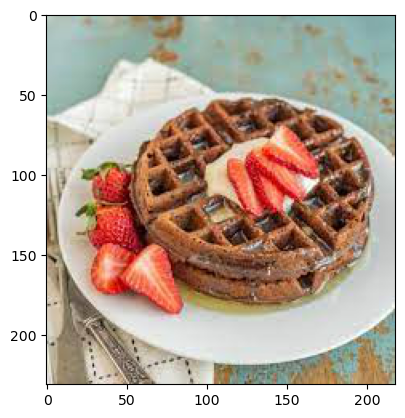

In [102]:
plt.imshow(custom_image_uint8.permute(1,2,0))

#### 11.2 Making a prediction on a custom image with a trained PyTorch model <a class='anchor' id ='custompred'>

In [103]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.7686, 0.7647, 0.7529,  ..., 0.5294, 0.5255, 0.5255],
         [0.7647, 0.7569, 0.7490,  ..., 0.5294, 0.5255, 0.5255],
         [0.7529, 0.7490, 0.7412,  ..., 0.5294, 0.5255, 0.5255],
         ...,
         [0.9255, 0.8863, 0.8078,  ..., 0.6039, 0.6353, 0.6078],
         [0.9216, 0.9098, 0.8118,  ..., 0.6627, 0.6549, 0.6235],
         [0.9098, 0.9373, 0.8275,  ..., 0.6863, 0.6824, 0.6431]],

        [[0.8353, 0.8314, 0.8196,  ..., 0.6941, 0.6902, 0.6902],
         [0.8314, 0.8235, 0.8157,  ..., 0.6941, 0.6902, 0.6902],
         [0.8196, 0.8157, 0.8078,  ..., 0.6941, 0.6902, 0.6902],
         ...,
         [0.9098, 0.8706, 0.7882,  ..., 0.5882, 0.6745, 0.6863],
         [0.9059, 0.8941, 0.7922,  ..., 0.6627, 0.7098, 0.7216],
         [0.8941, 0.9216, 0.8078,  ..., 0.6980, 0.7412, 0.7569]],

        [[0.7961, 0.7922, 0.7804,  ..., 0.6863, 0.6824, 0.6824],
         [0.7922, 0.7843, 0.7765,  ..., 0.6863, 0.6824, 0.6824],
         [0.7804, 0.7765, 0.7686,  ..., 0.6863, 0.6824, 0.

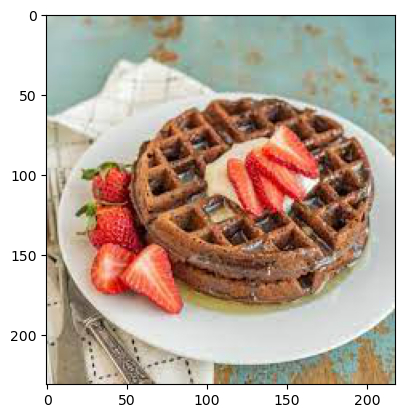

In [104]:
plt.imshow(custom_image.permute(1,2,0))

In [105]:
# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
    model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x2754 and 1690x5)

In [106]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform  = transforms.Compose([
                                            transforms.Resize(size = (64,64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 231, 218])
Transformed shape: torch.Size([3, 64, 64])


/Users/ritikagupta/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [107]:
custom_image.shape

torch.Size([3, 231, 218])

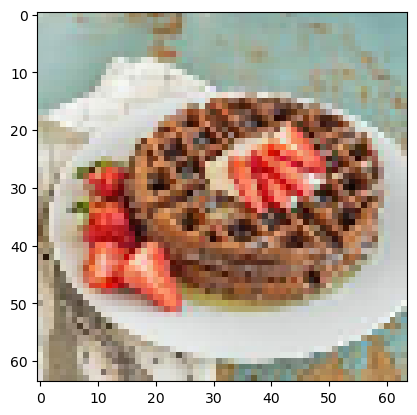

In [108]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [109]:
# This will error : no batch size

model_1.eval()
with torch.inference_mode():
    model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x5)

In [110]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [111]:
# This should work (added a batch size)
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[-0.5433, -1.1686, -0.4967, -1.9319,  1.3570]])

Note, to make a prediction on a custom image we had to :
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was the same shape as the data the model was trained on (64*64*3) with a batch size....(1,3,64,64)
* Make sure the image was on the same device as our model

In [112]:
class_names

['apple_pie', 'cheesecake', 'chocolate_mousse', 'red_velvet_cake', 'waffles']

In [113]:
# Convert logits -> prediction probabilities 
custom_image_pred_probs = torch.softmax(custom_image_pred, dim = 1)
custom_image_pred_probs

tensor([[0.1050, 0.0562, 0.1100, 0.0262, 0.7025]])

In [114]:
# Convert the prediction probabilities -> prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim = 1).cpu()
custom_image_pred_labels

tensor([4])

In [115]:
class_names[custom_image_pred_labels]

'waffles'

#### 11.3 Putting custom image prediction together: Building a function <a class='anchor' id ='buildfunction'>
    
Ideal outcome:
A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [116]:
def pred_and_plot_image(model       : torch.nn.Module,
                        image_path  : str,
                        class_names : List[str] = None,
                        transform   = None,
                        device      = device):
    """Makes a prediction on a target image with a trained model and plots the image and prediction."""
    # Load in the image
    target_image    = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # Divide the image pixel values by 255 to get them between (0,1)
    target_image    = target_image / 255.

    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Make sure the model is on target device
    model.to(device)

    # Turn on eval/inference mode and make a prediction
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on batches of 1x image)
        target_image         = target_image.unsqueeze(0)

        # Make a prediction on the image with an extra dimension
        target_image_pred    = model(target_image.to(device)) # make sure the target image is on the right device

    # Convert logits -> prediction probabilities
    target_image_pred_probs  = torch.softmax(target_image_pred, dim = 1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label  = torch.argmax(target_image_pred_probs, dim = 1)

    # PLot the image alongside the prediction and prediction probabilities
    plt.imshow(target_image.squeeze().permute(1,2,0)) # remove batch dimension and rearrange shape to be HWC

    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)
    

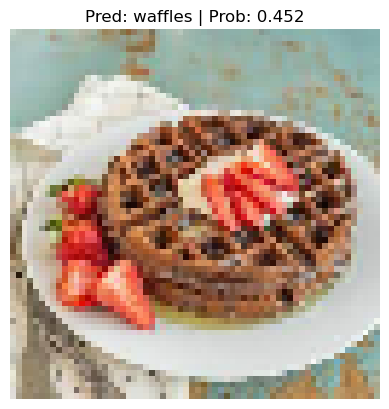

In [117]:
# Pred on our custom image
pred_and_plot_image(model      = model_0,
                    image_path = custom_image_path,
                    class_names= class_names,
                    transform  = custom_image_transform,
                    device     = device)

![Error](custom8.png)

### 12. Saving and loading the best model <a class='anchor' id ='savemodel'>

In [127]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents  = True,
                 exist_ok = True)

# Create model save
MODEL_NAME      = "04_pytorch_custom_datasets_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH/ MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_2.state_dict(),
           f   = MODEL_SAVE_PATH)

Saving model to: models/04_pytorch_custom_datasets_model_2.pth


In [128]:
model_2.state_dict

<bound method Module.state_dict of ImprovedTinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [131]:
# Create a new instance
torch.manual_seed(42)
loaded_model_2 = ImprovedTinyVGG(input_shape  = 3,
                                 hidden_units = 3,
                                 output_shape = len(class_names)
                                    )

# Loaded in the save state_dict()
loaded_model_2.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

# Send the model to the target device
loaded_model_2.to(device)

ImprovedTinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequenti